# Bibliothèques

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 51)
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn : apprentissage automatique
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config # Pour afficher les pipelines
set_config(display='diagram')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Learning curve avec yellowbrick
from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC

import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import norm, kurtosis
import pylab

# statmodel
import statsmodels.api as sm

# import warnings
# warnings.filterwarnings("ignore")

# Catalogue des fonctions

## Datavisualisation

In [2]:
# Datavisualisation

def analyse_dtypes_object(data):
    '''Modalités pour les variables qualitatives triées par nombre
    '''
    return data.select_dtypes(include=('object')).nunique().sort_values(ascending=False)


def analyse_dtypes_numeric(data):
    '''Modalités pour les variables quantitatives triées par nombre
    '''
    return data.select_dtypes(include=('integer', 'float')).nunique().sort_values(ascending=False)


def analyse_target(data):
    '''Répartition en % des modalités de la target
    '''
    number = data.readmitted.value_counts()
    percentage = data.readmitted.value_counts(normalize=True).round(3)*100
    analyse_target = {'number': number, '%': percentage}
    analyse_target_1 = pd.DataFrame(analyse_target)
    return analyse_target_1

def check_null_values(df):
    ''' Pourcentage de valeurs nulles par colonne
    '''
    nb_null = df.isnull().sum().sort_values(ascending=False).head(10)
    percentage_null = df.isnull().sum()*100/len(df)
    percentage_null = percentage_null.sort_values(ascending=False).head(10).round(1)
    null = {'nombre_null' : nb_null,'%_null' : percentage_null}
    data = pd.DataFrame(data = null)
    return data

def chi_2(col_1, col_2):
    table_diag = pd.crosstab(df[col_1], df[col_2], margins=True, margins_name='Total')
    chi_2, pvalue, degrees, expected = chi2_contingency(table_diag)
    print(f'Chi 2: {chi_2}, p_value: {pvalue}')

def map_missing_values(data):
    '''Cartographie des valeurs manquantes du dataset (couleur noire)
    '''
    plt.figure(figsize=(17,7))
    heatmap = sns.heatmap(data.isna(), cbar=False, cmap="Blues")
    heatmap.set_title('Heatmap des valeurs manquantes du dataset',
    fontdict={'fontsize':18}, pad=16);

def modalites(df):
    # Ajouter dans la fonction le paramètre de colonne (si on veut n'en sélectionner qu'une)
    ''' Pour chaque colonne indique les modalités et leur nombre
    '''
    for i in df.columns:
        print(f'{i}: {df[i].unique()}')
        print(f'Nb de modalités : {df[i].value_counts().count()}\n')

        
def skewness(df):
    ''' Indique la nature de la distribution : normale, biaisée, très biaisée
        df peut se présenter sous cette forme (df[['', '']])
    '''
    for col in df.columns:
        result = df[col].skew()
        print(f' Skewness of {col}: {result}')

## Preprocessing

In [3]:
def age_transform_to_numeric(df):
    '''Transforme la colonne âge (en object par intervalle) par une variable numérique
       On calcule la moyenne des extrêmes de l'intervalle. 
    '''
    df = df.replace({'age' : 
                            {'[0-10)' : 5, 
                             '[10-20)' : 15, 
                             '[20-30)' : 25, 
                             '[30-40)' : 35, 
                             '[40-50)' : 45,
                             '[50-60)' : 55,
                             '[60-70)' : 65,
                             '[70-80)' : 75,
                             '[80-90)' : 80, 
                             '[90-100)' : 95}
                            })
    return df



def columns_with_special_character(data, character = ''):
    ''' Retourne les colonnes présentant le caractère spécial indiqué
    '''
    # Améliorer la fonction avec un print ("aucune colonne impactée")
    list = []
    [list.append(i) for i in data.columns if np.any(data[i] == character)]
    for i in list:
        number = data[i] == character
        total = number.sum()
        print(f'La colonne "{i}" en contient : {total}')

def diag_1_transform(df):
    ''' Transforme la colonne diag_1 en variable binaire
        Si le premier diagnotique est le diabete = 1, else = 0
    '''
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == True] = 1
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == False] = 0
    return df

        
        
def base_clean_dataset():
    '''Permet de réinitialiser le dataset pré-nettoyé à chaque nouvelle itération 
    '''
    data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')
    data = data.replace({'?' : np.nan}).replace({'Unknown/Invalid' : np.nan})
    data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})
    data = data.drop(columns=['encounter_id', 'patient_nbr'])
    data = age_transform_to_numeric(data)
#     df = data.copy()
    return data


def medical_transform(df):   
    if df['medical_specialty'] == 'InternalMedicine':
        return 'Internal medicine'
    elif df['medical_specialty'] == 'Emergency/Trauma':
        return 'Trauma'
    elif df['medical_specialty'] == 'Family/GeneralPractice':
        return 'General Practice'
    elif df['medical_specialty'] == 'Cardiology':
        return 'Cardiology'
    elif df['medical_specialty'] == 'Pediatrics-Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology-Metabolism':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'
    
    
def remove_outliers(df, col_name):
    ''' Supprime les outliers de la variable numérique indiquée
    '''

    # Définit les percentiles 25% et 75% et calcule le IQR
    Q1 = np.percentile(df[col_name], 25)
    Q3 = np.percentile(df[col_name], 75)
    IQR = Q3 - Q1

    print("Old Shape: ", df.shape)

    # Détection des outliers (fourchette haute et basse)
    upper = np.where(df[col_name] >= (Q3+1.5*IQR))
    lower = np.where(df[col_name] <= (Q1-1.5*IQR))

    # Suppression des outliers

    df = df.reset_index(drop=True)  
    df = df.drop(upper[0], axis=0) 
    df = df.drop(lower[0],axis=0)
    
    print("New Shape: ", df.shape)
    return df

## Entrainement du modèle

In [4]:
def evaluation_cv(model, X, y):
    
    # Entraînement du modèle
    model.fit(X, y)
    
    # Métriques à tester
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    
    # Score des métriques
    for score in scoring: 
        print(f'Score {score} en cv : {cross_val_score(model, X, y, scoring = score, cv=5)}')
        print(f'Score {score} moyen en cv : {cross_val_score(model, X, y, scoring = score, cv=5).mean()}')
        print('')

    # Learning curve pour chacune des métriques 
    for score in scoring: 
        
        print(f'Pour {score} :')
        
        visualizer = LearningCurve(model, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4, 
                                   scoring = score)

        visualizer.fit(X, y) # Fit the data to the visualizer
        custum_title = visualizer.ax
        custum_title.set_title("Learning curve pour le score : {score}")
        visualizer.show() # Finalize and render the figure

        print('------------------------------------------------')

# Import du dataset

In [ ]:
data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')

In [ ]:
data.head()

# Principales informations

## Source et vue d'ensemble du dataset  

Ce dataset est hébergé sur le site opensource du "Center for Machine Learning and Intelligent Systems" de l'Université de Californie, qui regroupe des données permettant de faire du machine learning. 

Notre dataset traite du diabète et représente les données sur 10 ans (1999-2008), de 130 hôpitaux américains, des patients ayant été admis (patients hospitalisés) pour ce type de problème : https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

Le dataset compte 101766 exemples et 50 features. Chaque ligne correspond à l'admission unique d'un patient. A noter qu'un patient peut être admis plusieurs fois. Le nombre de patients total ayant été admis sur la période est de 71518. 


In [ ]:
data.shape

In [ ]:
data['encounter_id'].nunique(), data['patient_nbr'].nunique()

## Quelles sont mes variables ?

Le dataset présente des variables relatives aux caractéristiques physiques du patient, à la nature de sa prise en charge médicale (spécialité du médecin, temps d'hospitalisation...), à ses traitements médicaux et à ses résultats de tests de sanguins : 

|Variable| |Description| |Remarques|
|--------| |----------- | |---------|
|encounter_id| |identifiant unique de l'admission| ||
|patient_nbr| |identifiant unique du patient| || 
|race| |Caucasian, AfricanAmerican, Other, Asian, Hispanic| ||
|gender| |homme ou femme| 
|age| |groupé par des intervalles de 10 années| ||
|weight| |poids du patient en livre| |A TRADUIRE EN KG|
|admission_type_id| |id correspondant à 8 modalités (Emergency, Urgent, Elective, Newborn, Not Available, NULL, Trauma Center, Not Mapped| |voir dans le détail à quoi cela correspond|
|discharge_disposition_id| |lieu de transfert après guérison - 26 modalités (voir fichier excel) - A la maison, dans un autre service, etc.| ||
|admission_source_id| |raison de l'admission (recommandation médicale/urgence/enfant malade..) / 17 modalités|   
|time_in_hospital| |nombre de jours entre l'admission et la sortie (va de 1 à 14 jours)|
|payer_code| |unique ID assigné à chaque compagnie| |RETROUVER NOM ENTIER DE CHAQUE MODALITE|
|medical_specialty| |correspond à la spécialité du médecin qui a pris en charge le patient à son arrivée - 73 modalités|
|num_lab_procedures| |nombre de tests labo faits pendant l'hospitalisation||Analyses médicales -> vérifier)
|num_procedures||nombre de procédures (interventions) autre que les tests en labo|
|num_medications||nombre de type de médicaments administrés durant le séjour hospitalier||
|number_outpatient||nombre de visites ambulatoires du patient dans l'année précédant la consultation (consultation externe/soins de ville)|
|number_emergency||nombre de visites aux urgences du patient dans l'année précédant la consultation|
|number_inpatient||nombre de visites hospitalières du patient dans l'année précédant la consultation|
|diag_1/2/3||premier, second et diagnostique additionnel. Correspond au code ICD9 (documentation pour la classification : https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9)|
|number_diagnoses||nombre de diagnostics déclarés dans le système|
|max_glu_serum||4 modalités - Glycémie à jeun||A vérifier|
|A1Cresult||HbA1c = hémoglobine glyquée|
|medications : de metformin à metformin-pioglitazone||types de médicaments pris avec 4 modalités (régulier, pas pris, augmenté, diminué)|
|change||indique s'il y a eu un changement dans la traitement pour le diabète, soit dans la posologie, soit dans le nom du médicament|
|diabetesMed||prescription de médicaments pour le diabète ou pas|
|readmitted||le patient a-t-il été réadmis au bout de 30 jours max, à plus de 30 jours ou pas réadmis ?||target|

In [ ]:
# Nature et nombre de modalités pour chacune des colonnes

modalites(data)

## La target : réadmission ou non du patient

Notre target est la variable 'readmitted' : il s'agira de prédire si, au regard des caractéristiques ci-dessus, le patient sera réadmis ou non ultérieurement dans le service diabétologie.

Nous avons là deux possibilités :  
    - effectuer une classification mutliclasse (dans ce cas, vérifier le déséquilibre des classes et le corriger avec la méthode Smote par exemple)   
    - rassembler la target en une variable binaire (0 = pas de réadmission / 1 = réadmission (>30 et <30))

In [ ]:
data.readmitted.value_counts().plot.pie()
plt.show()

# Traitement nécessaire avant exploration des données

## Analyse des caractères anormaux du dataframe

Nous observons deux types de données que nous qualifions d'anormaux : 
- des "?" que nous allons remplacer par des NaN 
- des "None" dont nous allons devoir analyser la nature et déterminer la signification

### Les points d'interrogation

In [ ]:
# Colonnes avec points d'interrogation

columns_with_special_character(data, '?')

In [ ]:
# Remplacement des ? par des nan

data = data.replace({'?' : np.nan})
columns_with_special_character(data, '?') # on vérifie qu'on n'a plus de colonnes impactées

### Gestion des valeurs "None"

In [ ]:
columns_with_special_character(data, 'None')

In [ ]:
data['max_glu_serum'].value_counts()

Les deux colonnes impactées par ces None concernent les prises de sang liées à la mesure du glucose. Après vérification dans la littérature et analyse de la variable, cela signifie que le test n'a pas été effectué. Cela est différent que de ne pas avoir la donnée (Nan). Le test n'a sûrement pas été réalisé pour des raisons médicales. Il est donc intéressant de conserver cette donnée comme modalité en tant que telle. En revanche, au regard du nombre important, il faudra être attentif à la façon dont gérer cette classe déséquilibrée et/ou l'encodage. 

### "Unknown/Invalid"

In [ ]:
columns_with_special_character(data, 'Unknown/Invalid')

Il n'y a que 3 modalités, nous la qualifions en Nan et verrons plus tard si nous devons la supprimer ou l'encoder. 

In [ ]:
data = data.replace({'Unknown/Invalid' : np.nan})

## Suppression de l'Id

Variable integer inutile qui va parasiter notre modèle.

In [ ]:
data = data.drop(columns=['encounter_id'])

## Vérification des doublons

On ne constate aucun doublon.

In [ ]:
data.duplicated(keep=False).sum()

## Encodage de la target

Notre intérêt ici est de savoir si le patient, lors de son admission, sera de nouveau hospitalisé ou non. Nous ne prenons pas en compte la granularité de temps (à moins ou plus de 30 jours). Nous optons donc pour une variable binaire et non multiclasse.

In [ ]:
data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})

In [ ]:
# nb d'exemples pour chaque modalité de la colonne readmitted

data.readmitted.value_counts(normalize=True)

# Itération 1 : baseline

**Objectif** : créer un modèle prédictif simple, basé sur une analyse exploratoire et une data préparation sommaires afin de comprendre un peu mieux la structure du dataset et de pouvoir élaborer une ébauche de l'application demandée. 

In [ ]:
# Copie du dataset nettoyé des informations inutiles

baseline = first_clean_dataset_create_copy()

## Analyse de forme des données

**- Target** : readmitted - la classe est équilibrée (0 : 53% / 1 : 46%)  
**- Lignes et colonnes** : 101766 lignes et  49 colonnes  
**- Types de variables** : int64 = 13, object = 36 dont 5 avec plus de 10 modalités  
**- Valeurs manquantes**: 7 colonnes ont des valeurs manquantes dont 'weight' à hauteur de 96%. 'medical_specialty' et 'payer_code' manquent respectivement à 49% et 40%. 

### Structure du dataset

In [ ]:
# Répartition des modalités de la target 'readmitted'
  
analyse_target(baseline)

In [ ]:
# Nombre de Lignes et colonnes

baseline.shape

### Types de variables

A ce stade, nous avons 36 variables qualitatives dont 5 contiennent plus de 10 modalités, et 13 quantitatives.  

In [ ]:
baseline.dtypes.value_counts()

In [ ]:
# Répartition du type de variables

baseline.dtypes.value_counts().plot.pie()
plt.show()

In [ ]:
analyse_dtypes_object(baseline)

### Valeurs nulles

In [ ]:
# Cartographie des valeurs nulles 

map_missing_values(baseline)

In [ ]:
# Pourcentage de valeurs nulles

check_null_values(baseline)

7 colonnes ont des valeurs manquantes dont 'weight' à hauteur de 96%. 'medical_specialty' et 'payer_code' manquent respectivement à 49% et 40%.

## Pre-processing

### Suppression des valeurs nulles

Pour notre modèle experimental (baseline), nous décidons de supprimer les colonnes qui ont plus de 30% de valeurs nulles (weight, medical_specialty, payer_code) et toutes les lignes possédant au moins une valeur nulle. 
Notre dataset se compose désormais de 98 052 exemples et 46 colonnes.

In [ ]:
# Suppression des colonnes ayant plus de 30% de valeurs nulles (isna)
# Suppression des lignes ayant au moins une valeur nulle(dropna)

baseline = baseline[baseline.columns[baseline.isna().sum()/baseline.shape[0] <0.3]]
baseline = baseline.dropna()

In [ ]:
check_null_values(baseline)

In [ ]:
baseline.shape

### Transformation de la variable "age"

La colonne "age" est classée selon un intervalle avec 10 modalités (object). 
Point d'attention : cette donnée perd en qualité car on ne sait pas comment la donnée initiale a été transformée.  
Creuser pour savoir comment traiter une variable qui a été encodée selon un intervalle. En attendant, nous allons la transformer en variable numérique en prenant la moyenne des extrêmes de l'intervalle. On aurait pu aussi envisager de faire un Ordinal encorder. 

In [ ]:
baseline = baseline.replace({'age' : 
                            {'[0-10)' : 5, 
                             '[10-20)' : 15, 
                             '[20-30)' : 25, 
                             '[30-40)' : 35, 
                             '[40-50)' : 45,
                             '[50-60)' : 55,
                             '[60-70)' : 65,
                             '[70-80)' : 75,
                             '[80-90)' : 80, 
                             '[90-100)' : 95}
                            })

In [ ]:
baseline['age'].dtypes

### Sélection des variables et split

De notre baseline, nous voulions exclure :    
- les variables qui n'ont qu'une modalité (examide/citoglipton) car elles n'apportent rien au modèle
- les variables à plus de 10 modalités (diag_1/2/3) car elles vont créer de multiples dimensions lors de l'encodage, ce qui peut être lourd et et créer du bruit dans notre algorithme de régression logistique
- la variable "patient_nbr" qui est un ID unique

Et donc conserver certaines variables qualitatives (encodées). Or, cela perturbait notre modèle. Le temps d'exécution était très long et le score restait le même avec ou sans. De ce fait, pour cette première itération/baseline, je n'ai entrainé mon modèle qu'avec les features numériques (hors discharge_disposition_id, admission_source_id, admission_type_id qui sont des integer mais correspondant à des modalités).  

In [ ]:
baseline = baseline.drop(columns=['diag_3', 'diag_2', 'diag_1', 'citoglipton', 'examide', 'metformin-rosiglitazone', 'patient_nbr'], axis=1)

In [ ]:
baseline.shape

In [ ]:
# Création du X et du y avec les seules variables quantitatives

# X = baseline.drop(columns=['readmitted'], axis=1)
X = baseline[['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
              'number_outpatient','number_emergency', 'number_inpatient', 'number_diagnoses','age']]
y = baseline[['readmitted']]

In [ ]:
# Split du dataset entre un jeu de données de train et de test

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=5, stratify=y)

print('Train set :', X_train.shape)
print('Test set :', X_test.shape)

### Encodage et normalisation (pipeline)

On crée un pipeline de pré-processing de façon à pouvoir transformer nos données plus facilement, et éviter d'avoir de la fuite de données (dataleakage) ou des données mal transformées. 

Pour le variables catégorielles, nous avions choisi d'utiliser le OneHotEncoder même si après l'EDA, il sera certianement plus pertinent parfois de faire un OrdinalEncoder (mettre un poids en fonction du degré d'importance).

Dans notre baseline, nous n'avons que des variables numériques, que nous allons standardiser (moyenne de 0 et écart-type de 1). En effet, les algorithmes de régression fonctionnent mieux sur des données standardisées. 

In [ ]:
# Distinction entre les variables numériques et catégorielles

numerical_features = X.select_dtypes(include=['float', 'integer']).columns.values
categorical_features = X.select_dtypes(include=['object']).columns.values

In [ ]:
numerical_features

In [ ]:
# handle_unknown = 'ignore' : pallier au fait que nous n'avons pas dans le X_test le même nombre de classes/modalités

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(sparse = False,  handle_unknown = 'ignore'))

In [ ]:
# make_column_transformer : permet d'appliquer les transformers sur les colonnes qu'on sélectionne

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                   (categorical_pipeline, categorical_features))

In [ ]:
preprocessor

## Entrainement du modèle et score

### Choix théorique du modèle et des métriques de performance

#### La régression logistique

Nous choisissons la régression logistique binaire comme premier estimateur pour construire notre premier modèle, pour sa simplicité d'exécution et de son interprétation. L'algorithme va nous permettre d'estimer la probabilité qu'une observation appartienne à la classe négative 0 (proba inf. à 50%) ou la classe positive 1 (prob sup. à 50%).

#### Les métriques de performance choisies : fonctions coût et algorithme de minimisation

Notre application d'aide à la décision médicale a pour objectif de prédire si un patient admis pour diabète sera de nouveau hospitalisé ou non. L'intérêt médical est de pouvoir assurer un suivi particulier et d'être vigilent envers les patients topés positif. 
Dans ce contexte, il nous faut donc éviter les faux négatifs : on ne veut pas prédire qu'une personne ne retournera pas l'hôpital alors qu'elle reviendra. Il est préférable qu'on dise qu'elle vienne, même si c'est une fausse alerte, plutôt que de penser qu'elle ne fera pas de nouveau une crise de diabète. Nous allons donc nous attacher à obtenir un bon RECALL.   
En revanche, nous ne voulons pas non plus que les hôpitaux soient "surchargés" par une masse de travail et un suivi précis de patients, donc il nous faut également limiter les faux positifs. Nous veillerons donc également à obtenir une PRECISION convenable.  
Dans la mesure où nous avons besoin d'un rapport entre la precision et le recall honorable, nous avons tout intérêt à veiller à ce que notre F1 SCORE soit optimisé (il calcule le rapport moyen entre les 2 métriques grâce à une moyenne harmonique).  
Enfin, nous serons attentifs à l'ACCURACY, qui nous permettra de vérifier la part de bonnes prédictions. 

S'agissant de l'algorithme qui va aider notre modèle à minimiser cette fonction coût, nous utiliserons pour le moment celle implémentée dans le module Logistic Regression de Sklearn, qui est celle des moindres carrés. Au regard de la taille de notre dataset, nous envisagerons lors d'une seconde itération d'appliquer le Stochastic Gradient Descent Classifier qui nous permettra d'appliquer l'algorithme de minimisation de la Descente de gradient et d'en ajuster les paramètres.  

### Entraînement & score en cross validation

#### Création du modèle avec le pipeline de preprocessing

In [ ]:
# Choix du model et pipeline de pre-processing

model_rlog = make_pipeline(preprocessor, LogisticRegression(random_state = 5, solver='lbfgs')) # solver='lbfgs' mis suite à message d'erreur

#### Evaluation du modèle et learning curve

In [ ]:
# Evaluation du modèle avec les 4 métriques et analyse de la learning curve

evaluation_cv(model_rlog, X_train, y_train.values.ravel())

**Recall**:    

Le score est de 0,39 en cross validation : pour toutes le observations actuellement positives (y_true), 39% ont été correctement classifiées. Ce qui est mauvais. L'objectif de la learning curve est de comprendre la structure de la donnée et d'avoir un train qui baisse (le modèle ne surapprend pas) et un test qui augmente (ce qui montre une bonne généralisation). Dans le cas du recall, on observe une convergence du train et du validation set à mesure que la donnée augmente, ce qui pourrait supposer une bonne généralisation.

Les zones ombrées autour des courbes mettent en avant la variabilité (écart-type au dessus et en dessous de la moyenne). La variabilité semble légèrement plus grande autour du train, ce qui laisse supposer que nous avons un problème de biais, confirmé par les mauvais résultats sur le train et le validation set. Nous avons de grandes erreurs sur les deux courbes, notre modèle ne parvient pas à faire de relations pertinentes entre les données lorsqu'il s'agit de minimiser les faux négatifs. A noter une plus grande variance encore sur le train en début d'entrainement, pouvant s'expliquer par un manque de données. 

Notre modèle souffre d'underfitting. 

**Precision**:

Le score est de 0,69 : pour toutes les observations classées en positif, 69% sont corrects.  
Il est meilleur que le recall. Avec une learning curve qui se comporte à peu près de la même façon que le recall. Notre modèle souffre de biais et est en underfitting.  

**Accuracy** :

Notre modèle explique à 61% la variance de notre target. Il est honorable mais doit être amélioré et ne peut être considéré comme fiable. 


**Conclusion** : 
Notre modèle gère mieux les prédictions lorsqu'il s'agit de minimiser les faux positifs, c'est à dire prédire qu'une personne reviendra en hospitalisation alors que ce ne sera pas le cas. Nous voulons atteindre cet objectif mais pas prioritairement, nous allons donc nous attacher à améliorer le score en recall. 
Il souffre clairement d'underfitting, ne parvenant pas à saisir les patterns de notre modèle.

**Pistes d'amélioration à envisager** :
- optimiser les hyperparamètres afin de mieux "guider" l'algorithme ou choisir un modèle plus puissant avec plus de paramètres
- fournir davantage de variables au modèle 
- fournir de meilleures variables à l'algorithme d'apprentissage (voir les transformations possibles) grâce à l'exploration des données (EDA)

- la regression logistique étant un modèle paramétrique, il conviendrait de vérifier que les principaux présupposés sont bien respectés, notamment la normalité et homoscédasticité des résidus

#### Matrice de confusion en cv

La matrice de confusion permet de comparer les résultats du modèle (prédictions) avec les valeurs réelles. 
Chaque ligne du tableau correspond à la classe réelle et chaque colonne à la classe prédite. 

In [ ]:
y_pred_cv = cross_val_predict(model_rlog, X_train, y_train.values.ravel(), cv=5)
y_pred_cv

In [ ]:
# Confusion matrix (on compare y_true et y_pred)
# Question : est-ce judicieux de faire la confusion matrix avec le y_train (non crossé et le y_pred_cv) ?

conf_cv = pd.DataFrame(confusion_matrix(y_train, y_pred_cv))
conf_cv = conf_cv.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
conf_cv= conf_cv.rename(index={0: 'Actual 0',1:"Actual 1"})
conf_cv 

Notre modèle fait de grosses erreurs lorsqu'il s'agit de prédire les vrais positifs : il a prédit que 22175 personnes ne seraient pas réhospitalisées alors que c'est le cas. Cela corrobore notre mauvais score sur le recall.  

#### Classification report

In [ ]:
# Classification report (classification_report(y_true, y_pred))

print(classification_report(y_train, y_pred_cv))

Interprétation du recall pour les 0 : parmi les observations actuellement négatives, 81% ont été correctement classifiées par mon modèle.  

### Score sur le train et le test

#### Score

In [ ]:
# Faire fonction où on fit/score/classification report/prédiction ? 

In [ ]:
# Entrainement
model_rlog.fit(X_train, y_train.values.ravel()) 

In [ ]:
# score sur le test

score_test = model_rlog.score(X_test,y_test)
score_test

In [ ]:
# Classification report sur le test

y_pred = model_rlog.predict(X_test)
print(classification_report(y_test, y_pred))

#### Courbe AUC/ROC

Elle met en corrélation le taux de faux positifs et le taux de vrais positifs.
Elle représente la performance attendue pour une estimation totalement aléatoire pour chaque patient, ce qui reviendrait à tirer à pile ou face : on peut s'attendre à un résultat correct dans la moitié des cas et incorrect dans l'autre moitié. La zone sous la ligne diagonale représente donc un AUC de 0.5. Si l’AUC est supérieure à O.5 pour un modèle de classification binaire, alors il est plus performant qu’une estimation aléatoire. La zone sous la courbe est une mesure de discrimination : plus elle est important, plus le modèle est capable de prévoir correctement la valeur de la réponse de l'observation.

In [ ]:
visualizer = ROCAUC(model_rlog, classes=["non_rehospitalisé", "rehospitalisé"])

visualizer.fit(X_train, y_train)       
visualizer.score(X_test, y_test)      
visualizer.show()  

Notre modèle est considéré comme plus performant qu'une simple prédiction aléatoire car supérieur à 0.5. Néanmoins, étant inférieur à 0.7, on en conclut qu'il ne fournit pas de discrimination appropriée, suffisante.  

### Score sur l'ensemble du data set

In [ ]:
# model.fit(X, y)

model_rlog.fit(X,y.values.ravel())

In [ ]:
model_rlog.score(X, y)

### Predict

In [ ]:
# Renvoie la prediction du label en fonction de X

y_hat = model_rlog.predict(X)
y_hat

In [ ]:
# Renvoie une probabilité pour chaque label
# Interprétation : L'item 25 a 56% d'appartenir à la classe 0 et 43% d'appartenir à la classe 1.

y_hat_proba = model_rlog.predict_proba(X)
y_hat_proba

## Pistes d'amélioration pour les itérations suivantes

Pour le choix du modèle : 
- la regression logistique étant un modèle paramétrique, il conviendrait de vérifier que les principaux présupposés :
    - échantillon représentatif
    - absence de multicolinéarité (tests avec le VIF par exemple)
    - normalité des résidus (voir comment afficher les résidus d'une classification binaire)
    - homoscédasticité des erreurs (variance)
- à défaut, utiliser un modèle non paramétrique tel que le DecisionTreeClassifier : si on obtient les mêmes scores, on en déduit que les présupposés de la régression logisitique sont réunis
- si la question des présupposés est remplie, tester le SGD Classifier afin d'utiliser un modèle plus puissant qui permet d'appliquer la Descente de Gradient (stochastique). Par ailleurs, ce modèle est recommandé pour les datasets dont le nombre d'exemples est supérieur à 100000. 

Pour enrayer l'underfiting : 
- optimiser les hyperparamètres afin de mieux "guider" l'algorithme 
- choisir un modèle plus puissant avec plus de paramètres (SDG Classifier ou XGBoost Classifier)
- fournir davantage de variables au modèle
- fournir de meilleures variables à l'algorithme d'apprentissage (voir les transformations possibles) grâce à l'exploration des données (EDA)



### Sauvegarde du modèle avec Joblib

D'après la documentation Sklearn (https://scikit-learn.org/stable/model_persistence.html), Joblib est plus efficace que piclke quand il s'agit de sauvegarder des modèles basés sur des algorithmes qui ont de nombreux paramètres et qui reposent sur de grands datasets. 

In [ ]:
import joblib 

In [ ]:
# Sauvegarde du modèle sous le fichier nommé 'model_joblib'

joblib.dump(model, 'model_joblib')

In [ ]:
# Lecture du modèle enregistré dans le fichier

model_joblib = joblib.load('model_joblib')

In [ ]:
# Visualisation du modèle tel qu'il a été enregistré

model_joblib

In [ ]:
# Test de prediction ave le modèle encapsulé dans le fichier joblib

prediction_joblib = model_joblib.predict(X)
prediction_joblib

# Itération 2

## EDA

In [5]:
df = base_clean_dataset()

In [6]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,5,NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,15,NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,25,NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,35,NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,45,NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0


In [7]:
df.shape

(101766, 48)

### Analyse de forme

- Identification de la target : readmitted
- Nb lignes et colonnes : 101766 lignes et 49 colonnes
- Types de variables : 13 variables quantitatives et 36 catégorielles. Il va être indispensable d'analyser plus précisément les variables catégorielles en termes d'encodage et de sélection car elles vont grandement influencer notre modèle. 
=> au regard du nombre important de features, il peut être intéressant dans un premier temps de mesure la variance des numériques et catégorielles afin de ne sélectionner que celles qui vont nous donner de l'information (VarianceThreshold() de sklearn pour les numériques et Anova pour les catégorielles).
- Identification des valeurs manquantes : 
    - pas bcp de colonnes avec des Nan
    - colonne "weight" >96% de Nan
    - "3 diag" à analyser pour voir s'il existe une logique dans les NAN car correspondent à des diagnostiques additionnels
    - payer_code"/medical_specialty : 40% / 50% de Nan => voir si relation entre l'assurance et la spécialité du médecin

In [8]:
df.dtypes.value_counts()

object    35
int64     13
dtype: int64

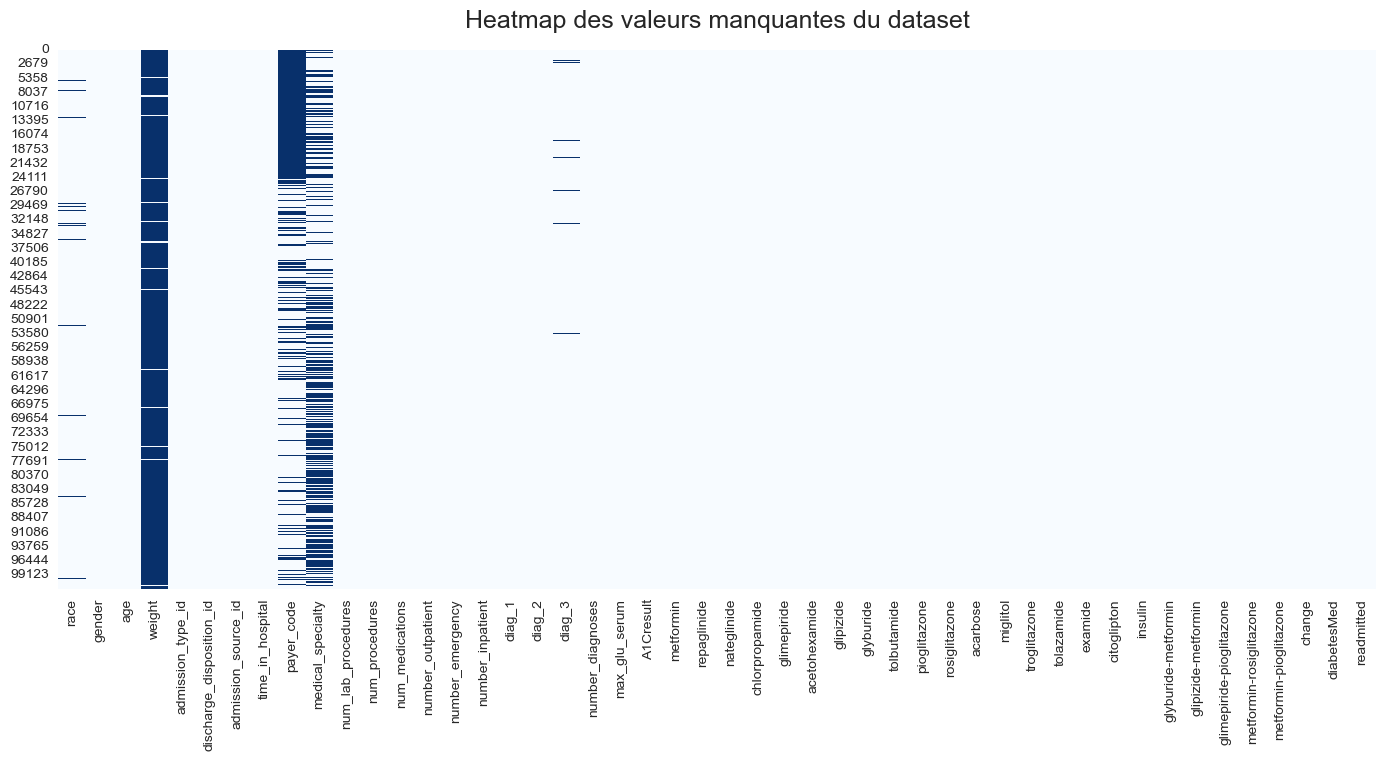

In [9]:
map_missing_values(df)

**Interprétation:**    

Valeurs manquantes (en noir):  
- Pas beaucoup de valeurs manquantes, sauf pour la colonne weight > 96% => sera à supprimer.  
- les 3 diag n'ont seulement que quelques valeurs manquantes => voir si cela est normal dans la hiérarchie et la compréhension de la variable (diag1, puis diag2 puis diag3) => dropna ?
- payer code : 40% de valeurs nulles => Khi2 qui montre corrélation avec la target => analyser comment gérer les valeurs nulles (suppression ou remplacement ?)
- medical_specialty ont quasiment le même nombre de valeurs nulles => voir s'il existe une relation entre elles (quand figuration ainsi, souvent c'est qu'il y a une relation - cf. Machine Learnia)
- genre et race comportent un petit pourcentage de valeurs nulles que l'on pourra supprimer

In [10]:
check_null_values(df)

,nombre_null,%_null
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0
gender,3,0.0
tolazamide,0,0.0
tolbutamide,0,0.0


### Analyse de fond

#### Elimination des colonnes inutiles

In [11]:
# Suppression des colonnes avec valeurs nulles > 90%  => colonne weight

df = df[df.columns[df.isna().sum()/df.shape[0] <0.9]]

In [12]:
df.shape

(101766, 47)

On est passé de 48 à 47 colonnes. 

In [13]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,5,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,15,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,25,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,35,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,45,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0


#### Analyse de la target

In [14]:
analyse_target(df)

,number,%
0,54864,53.9
1,46902,46.1


Nos classes sont bien équilibrées. 

#### Analyse univariée des variables numériques

In [15]:
analyse_dtypes_numeric(df)

num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
readmitted                    2
dtype: int64

##### Variables continues

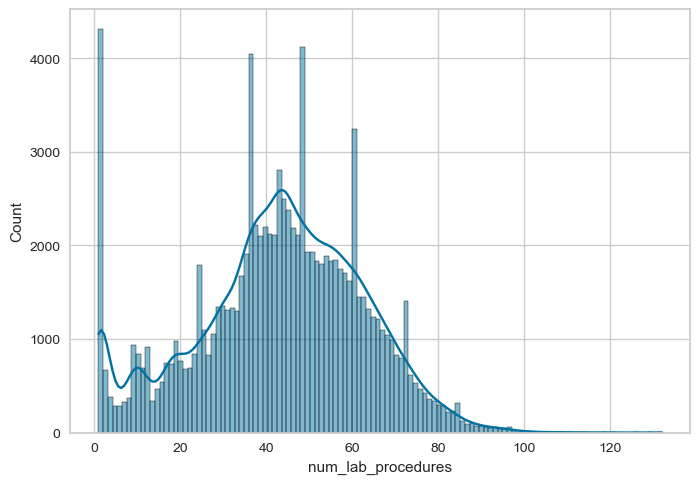

In [16]:
# "num_lab_procedures" (Nombre de tests de laboratoire effectués pendant l'admission)

sns.histplot(df['num_lab_procedures'], kde = True, bins=120)
plt.show()

La distribution semble suivre la loi normale car nous pouvons observer une belle courbe en cloche avec cependant la présence des valeurs aberrantes en début de courbe et en queue de distribution, biaisée vers la droite. 
On constate la présence de palliers lorsque l'on configure les bins (intervalles) à 120 : ce qui pourrait laisser penser que le nombre de procédures a peut-être parfois été arrondi lors du remplissage de la donnée (mais nous ne pouvons en être certain puisque nous n'avons pas les méthodes de collecte à notre disposition).  
On remarque par ailleurs, qu'au moins une analyse en laboratoire est effectuée puisque la distribution et le describe montre que la valeur minimum est 1. 

Au regard de cette distribution, deux idées nous viennent : 
- gérer les palliers et les outliers en faisant du feature engineering (en créant des classes) 
- supprimer les outliers en queue de distribution à droite afin de normaliser au mieux la distribution

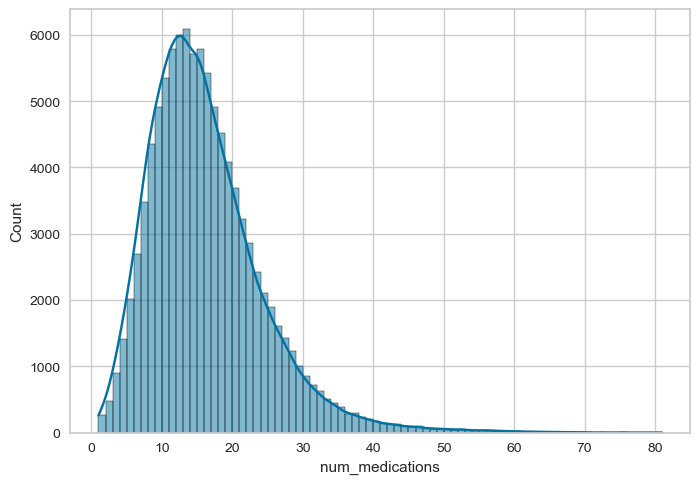

In [17]:
# "num medications" (nombre de type de médicaments administrés durant le séjour hospitalier)

sns.histplot(df['num_medications'], kde = True, bins=80)
plt.show()

Cette distribution suit la loi normale mais est biaisée à droite (skewed) montrant la présence d'outliers, qu'il conviendrait de supprimer aussi. En effet, notre modèle paramétrique est sensible aux outliers, ce qui risquera de biaiser notre modèle. Nous souhaitons généraliser au mieux et non détecter des comportements anormaux. Il conviendra alors de le supprimer. 

In [18]:
continuous_variables = df[['num_lab_procedures', 'num_medications']]
continuous_variables.describe()

,num_lab_procedures,num_medications
count,101766.000000,101766.000000
mean,43.095641,16.021844
std,19.674362,8.127566
min,1.000000,1.000000
25%,31.000000,10.000000
50%,44.000000,15.000000
75%,57.000000,20.000000
max,132.000000,81.000000


##### Variables discrètes

In [19]:
analyse_dtypes_numeric(df)

num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
readmitted                    2
dtype: int64

In [20]:
# On sélectionne les variables discrètes
variables_discrete = df[['number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'time_in_hospital', 'age', 'num_procedures']]

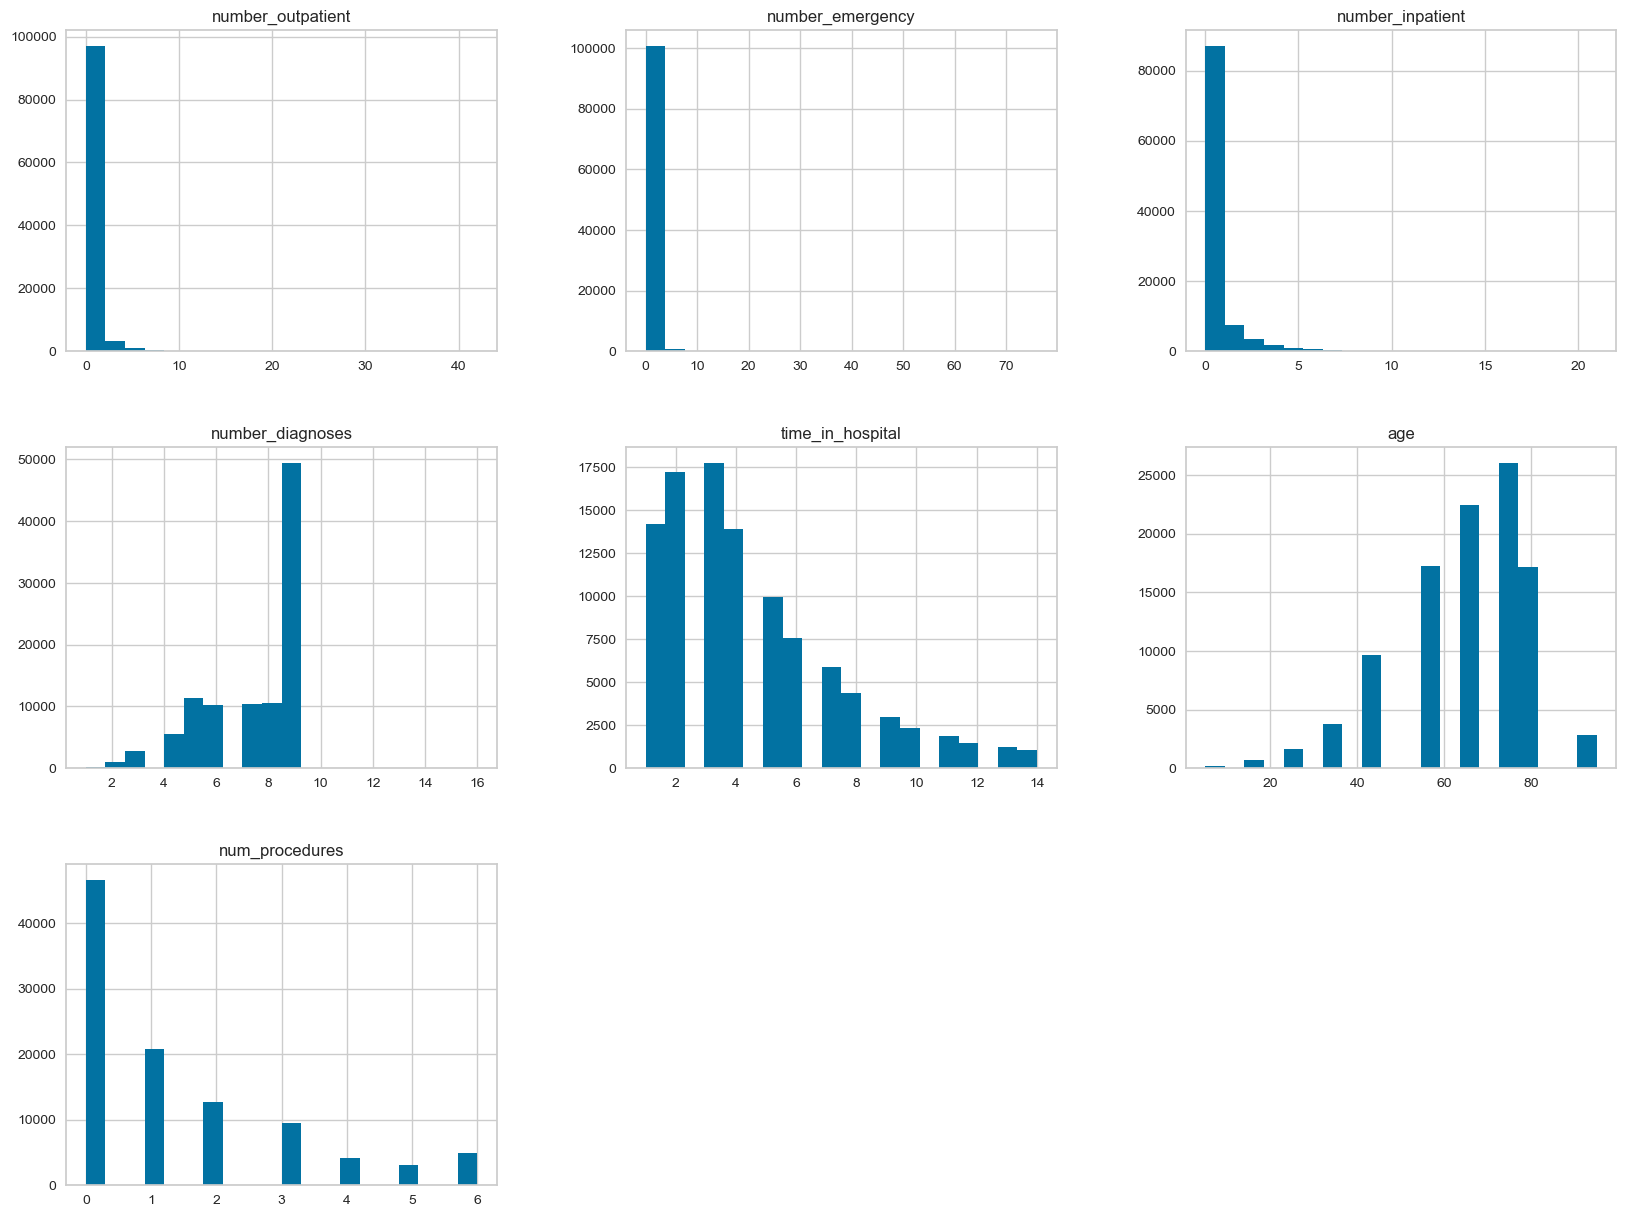

In [21]:
variables_discrete.hist(bins=20, figsize=(20,15))
plt.show()

**'number_outpatient', 'number_emergency', 'number_inpatient'**

La distribution des trois premières variables (number_outpatient, number_emergency, number_inpatient) qui correspondent, en termes de connaissance métier, au nombre de visites médicales qu'a eues le patient l'année précédente, est concentrée autour du zéro avec des outliers importants. Nous faisons un describe() pour analyser plus dans le détail la répartition en termes de quartiles. En effet, la variance est quasi-nulle, l'écart-type, qui rend compte de la dispersion des données, est très faible. La fonction VarianceThreshold avec un seuil à 3 corrobe notre hypothèse. 

Voir Géron p 48 pour explication de l'écart type et de la loi normale. 

In [22]:
variables_discrete.describe()

,number_outpatient,number_emergency,number_inpatient,number_diagnoses,time_in_hospital,age,num_procedures
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,0.369357,0.197836,0.635566,7.422607,4.395987,65.122094,1.339730
std,1.267265,0.930472,1.262863,1.933600,2.985108,15.015251,1.705807
min,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,0.000000
25%,0.000000,0.000000,0.000000,6.000000,2.000000,55.000000,0.000000
50%,0.000000,0.000000,0.000000,8.000000,4.000000,65.000000,1.000000
75%,0.000000,0.000000,1.000000,9.000000,6.000000,75.000000,2.000000
max,42.000000,76.000000,21.000000,16.000000,14.000000,95.000000,6.000000


In [23]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
selector = VarianceThreshold(threshold=2)
learn_variance = selector.fit(variables_discrete)
variance_result = learn_variance.get_support()
variance_result

array([False, False, False,  True,  True,  True,  True])

La fonction get_support() renvoit en fait un vecteur de booleen. Si la valeur est True celà signifie que la colonne peut être conservée, dans le cas contraire la variance de la colonne doit être supprimée. Pour savoir si la colonne doit être supprimée la fonction calcule la variance de la colonne et la compare à un seuil. Par défaut le seuil est à zéro. Cela signifie que seules les colonnes à variance nulle (c’est à dire celles qui ont une valeur constante) seront supprimées.

**number_diagnoses**  
Cette variable présente également des outliers et semble avoir été plafonnée à 9 : en effet, 75% des patients ont eu 9 diagnostics ou moins. Pour analyser à quel point la distribution est biaisée, nous essayer de mesurer le degré d'asyémtrie grâce à l'indicateur skew. 

Le skew est un coefficient de mesure du degré d'asymétrie de la distribution : 
*   Distribution normale : compris entre -0,5 et 0,5
*   Données modérément biaisées : compris entre -1 et -0,5 ou 0,5 et 1
*   Données sont fortement biaisées : inférieur à -1 ou supérieure à 1

L'asymétrie nous renseigne sur la direction de la valeur aberrante. 

In [25]:
skewness(df[['number_diagnoses']])

 Skewness of number_diagnoses: -0.8767462388449531


Le résultat du coefficient montre que les données sont modérément biaisiées vers la gauche.  
Voyons le résultat en ôtant les outliers.

In [26]:
df_remove_outl = remove_outliers(df, 'number_diagnoses')

Old Shape:  (101766, 47)
New Shape:  (101485, 47)


In [27]:
skewness(df_remove_outl[['number_diagnoses']])

 Skewness of number_diagnoses: -0.9039106216137414


Après avoir ôté les outliers, la variable est toujours modérement biaisée, mais un peu moins.  
Tentons de transformer avec le logarithme.

In [28]:
df_log = np.log(df['number_diagnoses'])

In [29]:
df_log.skew()

-1.741746664928519

Passer la variable en logarithme n'aide pas la distribution à mieux se comporter => nous allons donc nous contenter de supprimer les outliers. 

**time_in_hospital et num_procedures**   

Elles présentent une distribution clairement biaisée à droite qu'il conviendrait de normaliser si nous devons appliquer des tests statistiques qui requièrent la loi normale. Nous pouvons appliquer une transformation logarithmique (attention à l'interprétation des données en visualisation si on doit l'analyser car modifie l'échelle).

*time_hospital*

In [30]:
# On vérifie le score skew pour ces deux variables

skewness(df[['time_in_hospital','num_procedures']])

 Skewness of time_in_hospital: 1.133998719333879
 Skewness of num_procedures: 1.3164147632805119


Le skewness supérieur à 1, ce qui montre une distribution fortement biaisée pour les deux variables. 

On passe en logarithme la feature 'time_in_hospital'. Nous ne pouvons pas procéder de même avec 'num_procedures' parce que nous avons des valeurs nulles.

In [31]:
df_log_time = np.log(df['time_in_hospital'])

In [32]:
df_log_time.skew()

-0.2041595502088673

Le logarithme a permis de normaliser la distribution car le skew est désormais compris entre -0,5 et 0,5. 

*num_procedures*

*avec Kurtosis

In [ ]:
##################
### NE PAS BLOQUER SUR CA = REGARDER SKLEARN INTERPRETATION DE KURTOSIS
########################

In [33]:
df['num_procedures'].kurtosis()

0.857110302059521

Plus il est proche de 0, et plus il approche la loi normale. 
Testons de nous en rapprocher en supprimant les outliers. 

In [34]:
test_remove_outliers = remove_outliers(df, 'num_procedures')

Old Shape:  (101766, 47)
New Shape:  (93734, 47)


In [35]:
skewness(test_remove_outliers[['num_procedures']])

 Skewness of num_procedures: 1.023699439233688


In [36]:
test_remove_outliers['num_procedures'].kurtosis()

-0.07486480673726437

Les données sont un peu moins biaisées mais on s'éloigne quand même de la loi normale => voir si nous avons un intérêt à garder cette feature. 

*Avec Jarque_bera_test

La normalité nous permet de savoir si nous aurons un bon intervalle de confiance pour avoir des prévisions le plus fiable possible. On utilise le test Jarque Bera en positionnant que l'hypothèse nulle est que la variable suit la normalité. 

In [37]:
from scipy import stats

In [38]:
data = df['num_procedures']

In [39]:
jarque_bera_test = stats.jarque_bera(data)
jarque_bera_test

Jarque_beraResult(statistic=32505.976129570914, pvalue=0.0)

In [40]:
jarque_bera_test.statistic

32505.976129570914

In [41]:
jarque_bera_test.pvalue

0.0

La p_value est inférieure à 5%, on rejette alors l'hypothèse nulle, la variable ne suit pas la loi normale. 
Testons le jarque sur la variable dépourvue de ses outliers. 

In [42]:
jarque_bera_test_2 = stats.jarque_bera(test_remove_outliers['num_procedures'])
jarque_bera_test_2

Jarque_beraResult(statistic=16392.989814286517, pvalue=0.0)

Le résultat est toujours identique, la variable ne suit pas la loi normale.  
Nous décidons donc pour le moment de la supprimer de notre modèle paramétrique car nous ne parvenons pas à la normaliser. 

**age**  
Le distribution de âge semble suivre une représentation gaussienne, en démontre le describe. Nous avons un écart-type élevé et une médiane qui est égale à la moyenne (65 ans). L'âge moyen des personnes hospitalisées pour diabète est de 65 ans. 

In [43]:
df['age'].describe()

count    101766.000000
mean         65.122094
std          15.015251
min           5.000000
25%          55.000000
50%          65.000000
75%          75.000000
max          95.000000
Name: age, dtype: float64

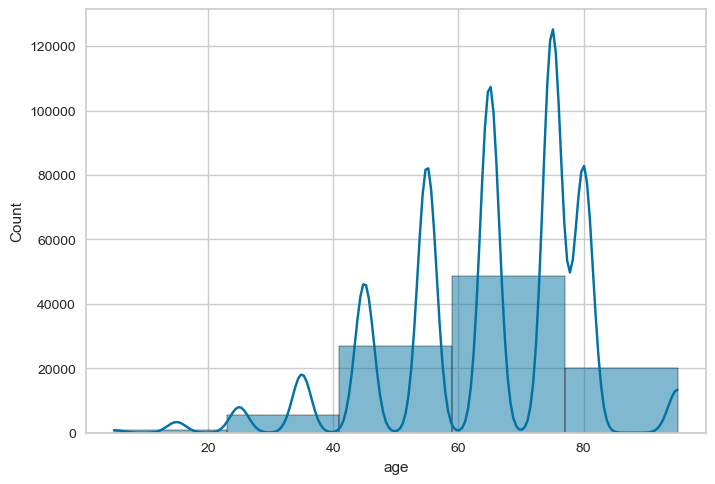

In [44]:
plt.figure()
sns.histplot(df['age'], kde = True, bins=5)
plt.show()

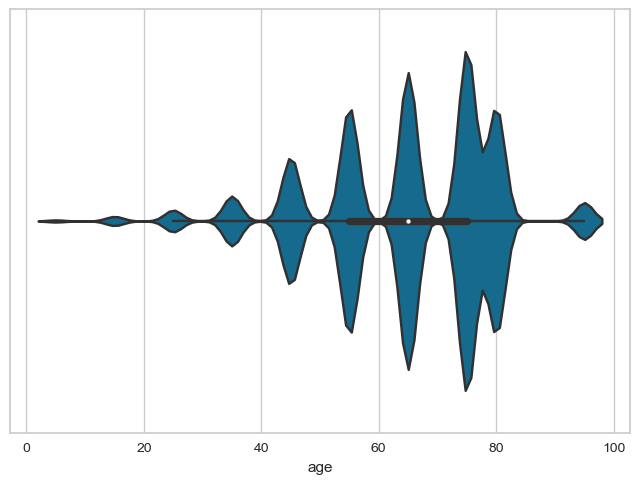

In [45]:
sns.violinplot(x=df['age'])
plt.show()

In [46]:
skewness(df[['age']])

 Skewness of age: -0.7917159691309223


Le score du skew montre tout de même des données légèrement biaisées. Nous pouvons rétablir cela en supprimant les outliers. 

In [47]:
test_remove_outl_age = remove_outliers(df, 'age')

Old Shape:  (101766, 47)
New Shape:  (99257, 47)


In [48]:
skewness(test_remove_outl_age[['age']])

 Skewness of age: -0.43330666916849647


Oter les outliers nous a permis de normaliser les données. 

##### Variables numériques ID qui correspondent à des modalités

In [49]:
analyse_dtypes_numeric(df)

num_lab_procedures          118
num_medications              75
number_outpatient            39
number_emergency             33
discharge_disposition_id     26
number_inpatient             21
admission_source_id          17
number_diagnoses             16
time_in_hospital             14
age                          10
admission_type_id             8
num_procedures                7
readmitted                    2
dtype: int64

**discharge_disposition_id**

Cette variable indique le lieu de sortie du patient : maison, maison avec soins, hôpital, etc. 

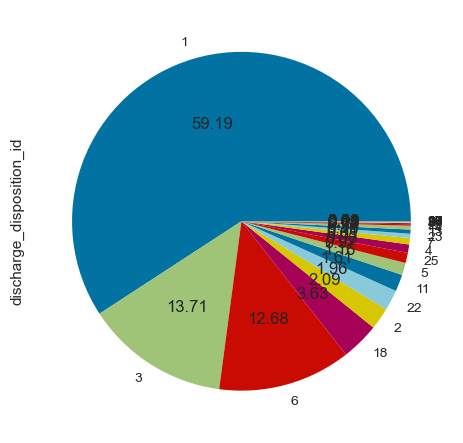

In [50]:
df['discharge_disposition_id'].value_counts().plot.pie(autopct='%.2f')
plt.show()

1,Discharged to home
2,Discharged/transferred to another short term hospital
3,Discharged/transferred to SNF
4,Discharged/transferred to ICF
5,Discharged/transferred to another type of inpatient care institution
6,Discharged/transferred to home with home health service
7,Left AMA
8,Discharged/transferred to home under care of Home IV provider
9,Admitted as an inpatient to this hospital
10,Neonate discharged to another hospital for neonatal aftercare
11,Expired
12,Still patient or expected to return for outpatient services
13,Hospice / home
14,Hospice / medical facility
15,Discharged/transferred within this institution to Medicare approved swing bed
16,Discharged/transferred/referred another institution for outpatient services
17,Discharged/transferred/referred to this institution for outpatient services
18,NULL
19,"Expired at home. Medicaid only, hospice."
20,"Expired in a medical facility. Medicaid only, hospice."
21,"Expired, place unknown. Medicaid only, hospice."
22,Discharged/transferred to another rehab fac including rehab units of a hospital .
23,Discharged/transferred to a long term care hospital.
24,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
25,Not Mapped
26,Unknown/Invalid
30,Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
27,Discharged/transferred to a federal health care facility.
28,Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
29,Discharged/transferred to a Critical Access Hospital (CAH).

=> ce qui vient à l'idée est de transformer la variable en bianire (0 = rentré à la maison sans soins particuliers (n°1) / 1 (les autres) = prise en charge à domicile ou hospitalière) qui formerait une variable à deux classes assez équilibrées 
=> voir ensuite au niveau de la visualisation si on a une variabilité avec les readmissions ou non

In [51]:
def discharge_disposition_transform(df):   
    if df['discharge_disposition_id'] == 1:
        return 0
    else:
        return 1

In [52]:
df['discharge_disposition_transform'] = df.apply(discharge_disposition_transform, axis=1)

In [53]:
df.head(2)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_disposition_transform
0,Caucasian,Female,5,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,1
1,Caucasian,Female,15,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,0


**admission_source_id** 

Correspond au type de service dans lequel le patient a été admis en premier lieu. 

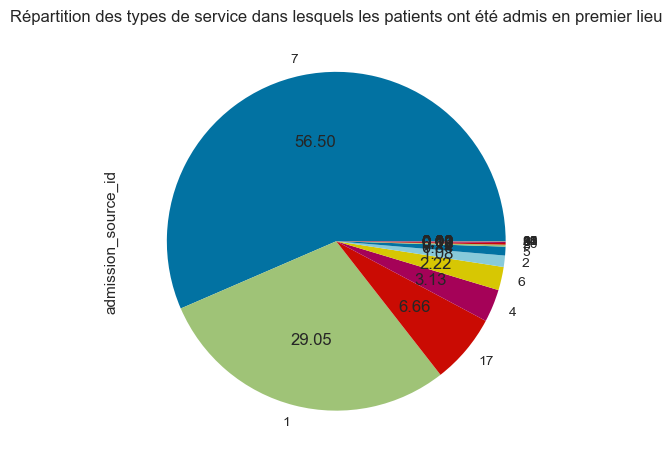

In [54]:
df['admission_source_id'].value_counts().plot.pie(autopct='%.2f', title='Répartition des types de service dans lesquels les patients ont été admis en premier lieu')
plt.show()

LE 7 correspond aux urgences, le 1 = venue sur recommandation/prescription médicale (= intéressant en termes de sens)  
=> créer une variable à 3 modalités : urgences, recommandation médicale et autres  
            => voir la variabilité en fonction de la réhospitalisation ou non

In [55]:
def admission_source_transform(df):   
    if df['admission_source_id'] == 7:
        return 'Urgences'
    elif df['admission_source_id'] == 1:
        return 'Prescription medicale'
    else:
        return 'Autres'

In [56]:
df['admission_source_transform'] = df.apply(admission_source_transform, axis=1)

In [57]:
df.head(2)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_disposition_transform,admission_source_transform
0,Caucasian,Female,5,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,1,Prescription medicale
1,Caucasian,Female,15,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,0,Urgences


**admission_type_id**  
Correspond à la raison pour laquelle le patient a été admis : recommandation médicale, urgence, enfant malade...

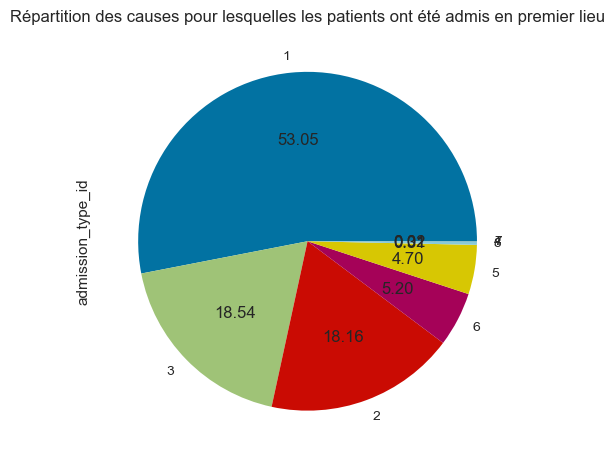

In [58]:
df['admission_type_id'].value_counts().plot.pie(autopct='%.2f', title='Répartition des causes pour lesquelles les patients ont été admis en premier lieu')
plt.show()

Le 1 = urgence, le 2 = urgent et le 3 = facultatif => ne comprend pas cette variable et n'ai pas trouvé de documentation sur le sujet donc pour l'instant, on la met de côté. 

#### Analyse univariée des variables catégorielles

In [59]:
analyse_dtypes_object(df)

diag_3                        789
diag_2                        748
diag_1                        716
medical_specialty              72
payer_code                     17
race                            5
glyburide-metformin             4
acarbose                        4
rosiglitazone                   4
pioglitazone                    4
insulin                         4
glyburide                       4
glipizide                       4
nateglinide                     4
glimepiride                     4
chlorpropamide                  4
repaglinide                     4
metformin                       4
A1Cresult                       4
max_glu_serum                   4
miglitol                        4
tolazamide                      3
admission_source_transform      3
troglitazone                    2
gender                          2
acetohexamide                   2
glipizide-metformin             2
glimepiride-pioglitazone        2
metformin-rosiglitazone         2
metformin-piog

**diag 1 / 2 / 3** 

Nous allons conserver les premiers et troisièmes diagnostics afin d'identifier si nous avons une différence entre les deux et une incidence sur le fait que le patient sera réhospitalisé ou non. 
Il sera intéressant dans un second temps de créer un nouvelle variable qui permettra de déterminer s'il y avait une différence de diagnotique entre les 1 et 3.   
Au regard du nombre important de modalités (716), il convient de faire du feature engineering. Nous allons nous aider du classement officiel ICD-9 sur lequel repose ces codes qui correspondent au "Diagnostic Code Descriptions" https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9

In [60]:
df['diag_1'].value_counts()

428    6862
414    6581
786    4016
410    3614
486    3508
       ... 
817       1
61        1
148       1
870       1
V51       1
Name: diag_1, Length: 716, dtype: int64

In [61]:
# On drop les Nan
df.dropna(subset='diag_1', inplace=True)
df['diag_1'].isnull().sum()

0

In [62]:
# On drop les Nan
df.dropna(subset='diag_3', inplace=True)
df['diag_3'].isnull().sum()

0

In [63]:
# Variable binaire = bon diagnostic de départ en diabete (1) et les autres (0)

df['diag_1'].loc[df['diag_1'].str.startswith('250') == True] = 1
df['diag_1'].loc[df['diag_1'].str.startswith('250') == False] = 0
df['diag_3'].loc[df['diag_3'].str.startswith('250') == True] = 1
df['diag_3'].loc[df['diag_3'].str.startswith('250') == False] = 0

C:\Users\Gwen\AppData\Local\Temp\ipykernel_10596\984540800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diag_1'].loc[df['diag_1'].str.startswith('250') == True] = 1
C:\Users\Gwen\AppData\Local\Temp\ipykernel_10596\984540800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diag_1'].loc[df['diag_1'].str.startswith('250') == False] = 0
C:\Users\Gwen\AppData\Local\Temp\ipykernel_10596\984540800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [64]:
df['diag_3'].value_counts()

0    83169
1    17154
Name: diag_3, dtype: int64

In [65]:
df['diag_1'].value_counts()

0    92186
1     8137
Name: diag_1, dtype: int64

**medical specialty**  

In [66]:
df['medical_specialty'].value_counts()

InternalMedicine                    14391
Emergency/Trauma                     7511
Family/GeneralPractice               7304
Cardiology                           5324
Surgery-General                      3028
                                    ...  
Speech                                  1
Pediatrics-InfectiousDiseases           1
Perinatology                            1
Neurophysiology                         1
Surgery-PlasticwithinHeadandNeck        1
Name: medical_specialty, Length: 72, dtype: int64

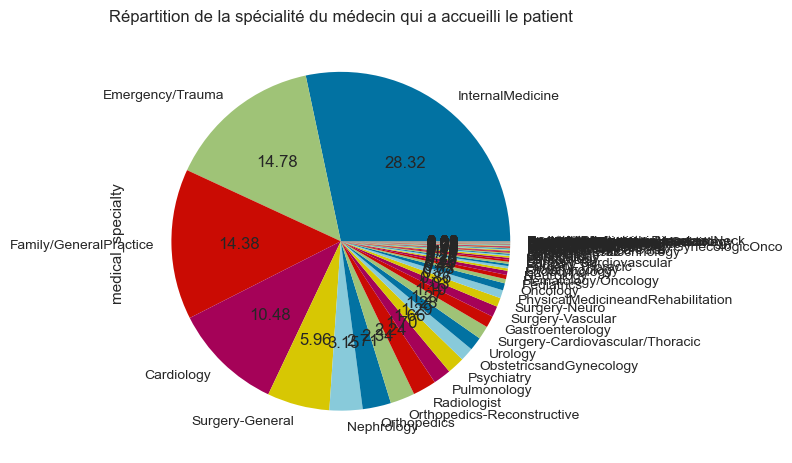

In [67]:
df['medical_specialty'].value_counts().plot.pie(autopct='%.2f', title='Répartition de la spécialité du médecin qui a accueilli le patient')
plt.show()

Au regard du nombre important de modalités, il convient de procéder à une transformation. En analysant le nombre total d'observations par modalités, nous constatons que des catégories émergent. 
Nous décidons de conserver les catégories suivantes : 
- InternalMedicine
- Emergency/Trauma 
- Family/GeneralPractice 
- Cardiology 
- Surgery-General 
- Endocrinology (car même s'il est peu représenté, il concerne la spécialité médicale qui traite des problèmes de diabète)
- Autres
- Inconnu pour les valeurs nulles

En effet, nous allons toper les valeurs nulles par 'Inconnu', à défaut de supprimer cette variable car nous avons beaucoup de valeurs nulles, et les supprimer nous ferait perdre beaucoup d'information. Par ailleurs, indiquer "Inconnu" peut avoir du sens en terme de connaissance métier : soit on n'a pas eu le temps de récupérer l'information, soit on ne connaissait vraiment pas la spécialité ou le service auquel était rattaché le médecin (dans ce cas, les résultats montreront peut-être qu'il conviendrait de déterminer la spécialité du médecin dès le départ).  

In [68]:
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_disposition_transform,admission_source_transform
1,Caucasian,Female,15,1,1,7,3,NaN,NaN,59,0,18,0,0,0,0,250.01,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,0,Urgences
2,AfricanAmerican,Female,25,1,1,7,2,NaN,NaN,11,5,13,2,0,1,0,250,0,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,0,Urgences
3,Caucasian,Male,35,1,1,7,2,NaN,NaN,44,1,16,0,0,0,0,250.43,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,0,Urgences
4,Caucasian,Male,45,1,1,7,1,NaN,NaN,51,0,8,0,0,0,0,157,1,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Urgences
5,Caucasian,Male,55,2,1,2,3,NaN,NaN,31,6,16,0,0,0,0,411,1,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,0,Autres


In [69]:
# Remplace les valeurs nulles par 'Inconnu'
df = df.replace({'medical_specialty' : {np.nan : 'Inconnu'}})
df.head(10)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_disposition_transform,admission_source_transform
1,Caucasian,Female,15,1,1,7,3,NaN,Inconnu,59,0,18,0,0,0,0,250.01,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,0,Urgences
2,AfricanAmerican,Female,25,1,1,7,2,NaN,Inconnu,11,5,13,2,0,1,0,250,0,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,0,Urgences
3,Caucasian,Male,35,1,1,7,2,NaN,Inconnu,44,1,16,0,0,0,0,250.43,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,0,Urgences
4,Caucasian,Male,45,1,1,7,1,NaN,Inconnu,51,0,8,0,0,0,0,157,1,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Urgences
5,Caucasian,Male,55,2,1,2,3,NaN,Inconnu,31,6,16,0,0,0,0,411,1,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,0,Autres
6,Caucasian,Male,65,3,1,2,4,NaN,Inconnu,70,1,21,0,0,0,0,411,0,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Autres
7,Caucasian,Male,75,1,1,7,5,NaN,Inconnu,73,0,12,0,0,0,0,492,1,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,1,0,Urgences
8,Caucasian,Female,80,2,1,4,13,NaN,Inconnu,68,2,28,0,0,0,0,427,0,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Autres
9,Caucasian,Female,95,3,3,4,12,NaN,InternalMedicine,33,3,18,0,0,0,0,198,0,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,1,Autres
10,AfricanAmerican,Female,45,1,1,7,9,NaN,Inconnu,47,2,17,0,0,0,1,403,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,0,Urgences


In [70]:
def medical_transform(df):   
    if df['medical_specialty'] == 'InternalMedicine':
        return 'Internal medicine'
    elif df['medical_specialty'] == 'Emergency/Trauma':
        return 'Trauma'
    elif df['medical_specialty'] == 'Family/GeneralPractice':
        return 'General Practice'
    elif df['medical_specialty'] == 'Cardiology':
        return 'Cardiology'
    elif df['medical_specialty'] == 'Pediatrics-Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Endocrinology-Metabolism':
        return 'Endocrinology'
    elif df['medical_specialty'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'

In [71]:
df['specialty_transform'] = df.apply(medical_transform, axis=1)

In [72]:
df['specialty_transform'].value_counts()

Inconnu              49513
Autres               16114
Internal medicine    14391
Trauma                7511
General Practice      7304
Cardiology            5324
Endocrinology          166
Name: specialty_transform, dtype: int64

**payer_code**

Cette feature comporte aussi beaucoup de valeurs nulles (40%). Avant de l'analyser plus en détail et d'entreprendre du feature engineering, nous pouvons gagner du temps en nous demandant si elle était corrélée à notre target et présente un intérêt.  
Nous allons analyser cette variable (exemptée de ses valeurs nulles) à travers un tableau de contingence (ou cross tab), qui va nous permettre de mesurer la fréquence à laquelle ses modalités apparaissent en fonction de la target.

In [73]:
# Tableau de contingence

table = pd.crosstab(df['readmitted'], df['payer_code'], margins=True, margins_name='Total')
table

payer_code,BC,CH,CM,CP,DM,FR,HM,MC,MD,MP,OG,OT,PO,SI,SP,UN,WC,Total
readmitted,,,,,,,,,,,,,,,,,,
0,2865,99,1076,1511,259,1,3255,16539,1826,31,554,50,400,29,2558,1460,103,32616
1,1706,46,856,987,277,0,2948,15722,1654,48,466,44,186,23,2345,911,28,28247
Total,4571,145,1932,2498,536,1,6203,32261,3480,79,1020,94,586,52,4903,2371,131,60863


Au regard du tableau de contingence, on ne note pas de discrimination visible entre ces deux variables. Mais vérifions tout de même cette hypothèse avec le test de Khi-2, qui va évaluer l'hypothèse nulle selon laquelle les deux variables (catégorielles) sont indépendantes. L’indépendance signifie que la valeur d’une des deux variables ne nous donne aucune information sur la valeur possible de l’autre variable. 

In [74]:
# Vérification de l'hypothèse de corrélation entre ces deux variables

chi_2, pvalue, degrees, expected = chi2_contingency(table)
chi_2, pvalue

(452.69834488386925, 1.217107883535164e-74)

La pvalue est bien inférieure à 5%, on peut donc rejeter l’hypothèse selon laquelle les deux variables testées sont indépendantes. Par définition, on peut dire que les deux variables sont dépendantes l’une de l’autre : la variation de l’une influence la variation de l’autre…

On choisit donc de conserver la feature pour laquelle il manque de nombreuses valeurs. Comme pour medical_specialty, on va remplacer les NULL par la valeur 'Inconnu' car cela réduirait beaucoup trop notre dataset (risque de perdre de l'information). 

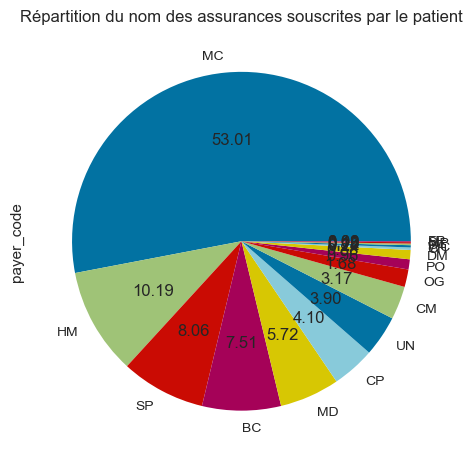

In [75]:
df['payer_code'].value_counts().plot.pie(autopct='%.2f', title='Répartition du nom des assurances souscrites par le patient')
plt.show()

N'ai pas trouvé de documentation sur ces codes mais ai voulu creuser l'acronyme "MC" : il semblerait qu'il s'agisse de "Medicare". En effet, c'est une assurance maladie américaine principalement fournie aux Américains âgés de 65 ans et plus, mais également à certaines personnes plus jeunes ayant un statut d'invalidité ou souffrant d'insuffisance rénale terminale ou de sclérose latérale amyotrophique. Vérifions si nos données vont dans ce sens en visualisant la distribution de l'âge en fonction de notre variable payer_code.

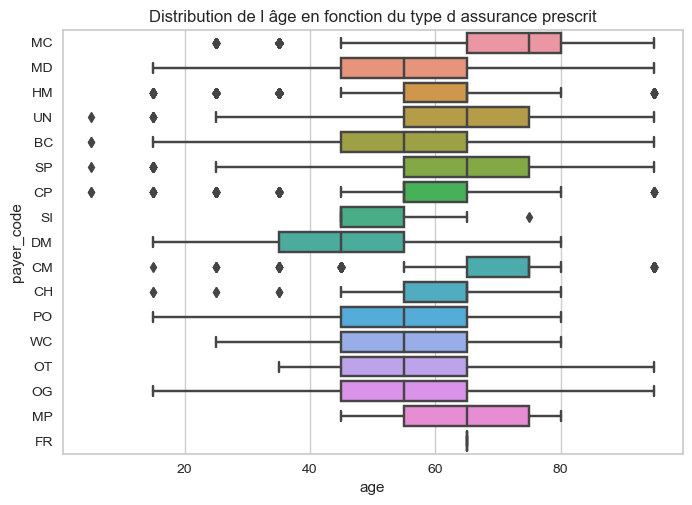

In [76]:
sns.boxplot(data=df, x="age", y="payer_code")
plt.title('Distribution de l âge en fonction du type d assurance prescrit')
plt.show()

Effectivement, la boite à moustaches montre que l'âge médian des personnes qui ont cette assurance est de 75 ans environ avec des quartiles 1 et 3 entre 65 et 80, ce qui corrobore qu'il s'agit bien de la souscription à Medicare. Les outliers en début de distribution correspondrait aux exceptions mentionnées dans la définition (jeunes malades).  
En conséquence de cette analyse, nous allons transformer cette variable entre : 
- MC (Medicare)
- SP (self-pay) : le fait de payer soit-même ses soins peut amener à écourter les analyses
- Autres
- Inconnu pour les NULL

In [77]:
# Remplace les valeurs nulles par 'Inconnu'
df = df.replace({'payer_code' : {np.nan : 'Inconnu'}})
df.head(10)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_disposition_transform,admission_source_transform,specialty_transform
1,Caucasian,Female,15,1,1,7,3,Inconnu,Inconnu,59,0,18,0,0,0,0,250.01,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,0,Urgences,Inconnu
2,AfricanAmerican,Female,25,1,1,7,2,Inconnu,Inconnu,11,5,13,2,0,1,0,250,0,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,0,Urgences,Inconnu
3,Caucasian,Male,35,1,1,7,2,Inconnu,Inconnu,44,1,16,0,0,0,0,250.43,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,0,Urgences,Inconnu
4,Caucasian,Male,45,1,1,7,1,Inconnu,Inconnu,51,0,8,0,0,0,0,157,1,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Urgences,Inconnu
5,Caucasian,Male,55,2,1,2,3,Inconnu,Inconnu,31,6,16,0,0,0,0,411,1,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,0,Autres,Inconnu
6,Caucasian,Male,65,3,1,2,4,Inconnu,Inconnu,70,1,21,0,0,0,0,411,0,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Autres,Inconnu
7,Caucasian,Male,75,1,1,7,5,Inconnu,Inconnu,73,0,12,0,0,0,0,492,1,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,1,0,Urgences,Inconnu
8,Caucasian,Female,80,2,1,4,13,Inconnu,Inconnu,68,2,28,0,0,0,0,427,0,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Autres,Inconnu
9,Caucasian,Female,95,3,3,4,12,Inconnu,InternalMedicine,33,3,18,0,0,0,0,198,0,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,1,Autres,Internal medicine
10,AfricanAmerican,Female,45,1,1,7,9,Inconnu,Inconnu,47,2,17,0,0,0,1,403,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,0,Urgences,Inconnu


In [78]:
df['payer_code'].value_counts()

Inconnu    39460
MC         32261
HM          6203
SP          4903
BC          4571
MD          3480
CP          2498
UN          2371
CM          1932
OG          1020
PO           586
DM           536
CH           145
WC           131
OT            94
MP            79
SI            52
FR             1
Name: payer_code, dtype: int64

In [79]:
def payer_code(df):   
    if df['payer_code'] == 'MC':
        return 'Medicare'
    elif df['payer_code'] == 'SP':
        return 'Self_pay'
    elif df['payer_code'] == 'Inconnu':
        return 'Inconnu'
    else:
        return 'Autres'

In [80]:
df['payer_code_transform'] = df.apply(payer_code, axis=1)

In [81]:
df['payer_code_transform'].value_counts()

Inconnu     39460
Medicare    32261
Autres      23699
Self_pay     4903
Name: payer_code_transform, dtype: int64

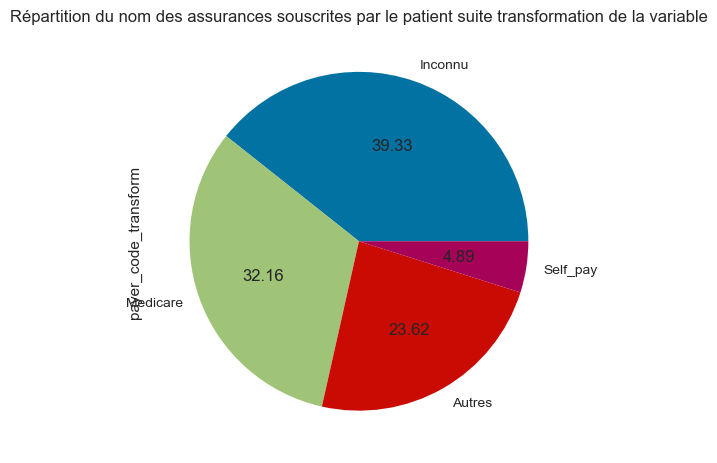

In [82]:
df['payer_code_transform'].value_counts().plot.pie(autopct='%.2f', title='Répartition du nom des assurances souscrites par le patient suite transformation de la variable')
plt.show()

**race & gender**

In [83]:
df['race'].value_counts()

Caucasian          75144
AfricanAmerican    18887
Hispanic            1986
Other               1484
Asian                625
Name: race, dtype: int64

In [84]:
df['gender'].value_counts()

Female    53964
Male      46356
Name: gender, dtype: int64

La variable 'gender' a deux classes équilibrées tandis que 'race' l'est un peu moins. Le Chi_2 montre une dépendance entre la target et ces variables. Il peut être intéressant de les conserver. On va donc les encoder. 

In [85]:
df[['race', 'gender']].describe()

,race,gender
count,98126,100320
unique,5,2
top,Caucasian,Female
freq,75144,53964


In [91]:
table_gender = pd.crosstab(df['gender'], df['readmitted'], margins=True, margins_name='Total')
table_gender

readmitted,0,1,Total
gender,,,
Female,28543,25421,53964
Male,25313,21043,46356
Total,53856,46464,100320


In [92]:
table_race = pd.crosstab(df['race'], df['readmitted'], margins=True, margins_name='Total')
table_race

readmitted,0,1,Total
race,,,
AfricanAmerican,10201,8686,18887
Asian,401,224,625
Caucasian,39722,35422,75144
Hispanic,1145,841,1986
Other,902,582,1484
Total,52371,45755,98126


In [93]:
chi_2, pvalue, degrees, expected = chi2_contingency(table_gender)
chi_2, pvalue

(29.427763956935564, 6.399200774762359e-06)

In [94]:
chi_2, pvalue, degrees, expected = chi2_contingency(table_race)
chi_2, pvalue

(87.5719014338937, 1.6206748230561673e-14)

**Change & diabetesMed**

Change indique s'il y a eu un changement dans le traitement pour le diabète (soit dans la posologie, soit dans le médicament prescrit).  
DiabetesMed indique s'il y a eu prescription de médicaments pour le diabète ou pas.   
=> Ces deux variables devraient être corrélées ? 

In [95]:
df['change'].value_counts()

No    53930
Ch    46393
Name: change, dtype: int64

In [96]:
df['diabetesMed'].value_counts()

Yes    77218
No     23105
Name: diabetesMed, dtype: int64

In [107]:
chi_2('change', 'diabetesMed')

Chi 2: 25823.194792780185, p_value: 0.0


Ces deux variables sont effectivement dépendantes. Il conviendrait de conserver celle qui est la plus corrélée à la target. 

In [108]:
chi_2('change', 'readmitted')

Chi 2: 203.50748922102238, p_value: 6.617711960092134e-43


In [109]:
chi_2('diabetesMed', 'readmitted')

Chi 2: 376.89152079139757, p_value: 2.732316550162937e-80


In [112]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [114]:
table_diab_change = pd.crosstab(df['change'], df['diabetesMed'], margins=True, margins_name='Total')
table_diab_change

diabetesMed,No,Yes,Total
change,,,
Ch,0,46393,46393
No,23105,30825,53930
Total,23105,77218,100323


In [115]:
chi_2, pvalue, degrees, expected = chi2_contingency(table_diab_change)
chi_2, pvalue

(25823.194792780185, 0.0)

In [172]:
obs = np.sum(table_diab_change)
obs

diabetesMed
No        46210
Yes      154436
Total    200646
dtype: int64

In [118]:
mini = min(table_diab_change.shape)-1
mini

2

In [119]:
result = chi_2/(obs*mini)
result

diabetesMed
No       0.279411
Yes      0.083605
Total    0.064350
dtype: float64

In [174]:
result[2]

0.06435013604253308

Le test de Cramer mesure le niveau de corrélation entre 2 variables catégorielles. Il renvoie une valeur entre 0 et 1. Si la valeur est supérieure à 0.9, la relation est très forte, si elle est inférieure à 0.1, elle est faible.  
On peut qualifier la relation entre nos deux variables de très faible, voire quasi-nulle. 

**Medication**

Les variables quantitatives liées à la prise de médicaments présentent des types de modalités différentes : 
- modalités distinctes avec répartition intéressante : 
    - max_glu_serum (glycémie à jeun), 
    - A1Cresult (hémoglobine glyquée), 
    - antidiabétiques oraux : metformin, glipizide, glyburide, pioglitazone, rosiglitazone
    - insulin (piqûre) 
- modalités avec peu de variabilité
- une seule modalité

Nous ne retenons que les variables avec des modalités distinctes. Rappelons que le None signifie que la prise de sang n'a pas été effectuée. 

Deux choix s'offrent à nous : 
- encoder les variables en ordinal en fonction du degré d'importance
- créer une nouvelle feature qui indiquerait si le patient prend ou non un antidiabétique oral

Nous nous contenterons pour le moment d'encoder les variables ordinalement.

#### Relation des variables avec la target 

##### Variables continues : num_lab_procedures / num_medications

In [120]:
readmitted = df[df['readmitted'] == 1]
no_readmitted = df[df['readmitted'] == 0]

In [124]:
readmitted.shape, no_readmitted.shape

((46464, 51), (53859, 51))

C:\Users\gwen\anaconda3\envs\diabete_readmission_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gwen\anaconda3\envs\diabete_readmission_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


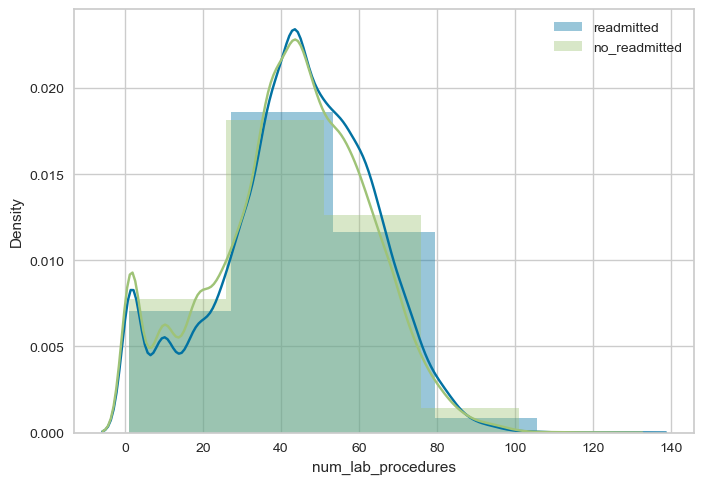

C:\Users\gwen\anaconda3\envs\diabete_readmission_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gwen\anaconda3\envs\diabete_readmission_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


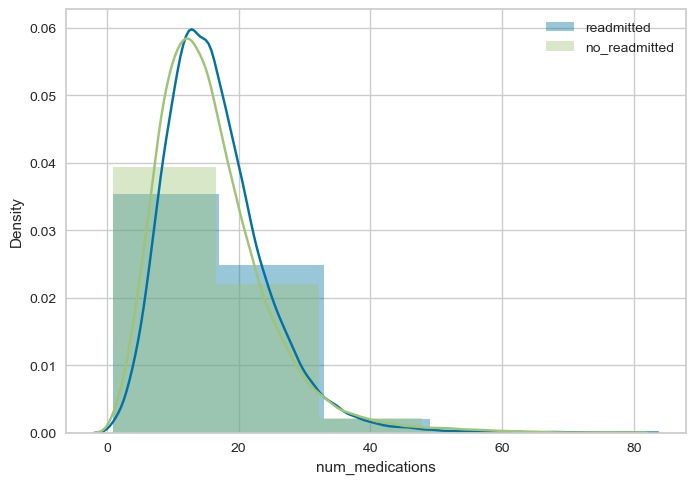

In [141]:
for col in continuous_variables:
    plt.figure()
    sns.distplot(readmitted[col], label = 'readmitted', bins=5)
    sns.distplot(no_readmitted[col], label = 'no_readmitted', bins=5)
    plt.legend()
    plt.show()

A priori, le nombre de médicaments pris ou de prises de sang effetuées ne semble pas avoir d'impact sur le fait d'être réadmis ou non pour des raisons de diabète.

Avec le t_test, on émet l'hypothèse nulle que les distributions sont égales pour les personnes réadmissent ou non. Pour cela, on utilise le test de student. Il permet de vérifier si la moyenne entre deux distribution est significativement différente. Le principe est d'essayer de rejeter cette hypothèse avec un seuil alpha souvent entre 2 et 5%, on calcule une valeur P avec test de student (ou Khi2). Si la valeur pest inférieur à notre seuil de probabilité alpha = on peut rejeter cette hypothèse, sinon on ne peut pas rejeter cette hypothèse.

Quand on utilise ce test, il vaut mieux avoir des classes balancées entre nos différents groupes (le nb de personnes + et - doivent être à peu près égales).

In [131]:
from scipy.stats import ttest_ind

In [137]:
alpha = 0.05
stat, p = ttest_ind(readmitted['num_lab_procedures'].dropna(), no_readmitted['num_lab_procedures'].dropna())
print(p)
if p < alpha:
     print('H0 Rejetée')
else :
    print('0')

3.899911648131104e-33
H0 Rejetée


In [138]:
alpha = 0.05
stat, p = ttest_ind(readmitted['num_medications'].dropna(), no_readmitted['num_medications'].dropna())
print(p)
if p < alpha:
     print('H0 Rejetée')
else :
    print('0')

1.3780046537364088e-42
H0 Rejetée


L'hypothèse nulle étant rejetée, d'après le t_student, les distributions sont tout de même différente. Il y aurait donc une variabilité intéressante pour ces deux features entre les personnes réhospitalisées ou non. Nous conservons donc ces variables dans notre modèle. 

In [142]:
continuous_variables.corr()

,num_lab_procedures,num_medications
num_lab_procedures,1.000000,0.268161
num_medications,0.268161,1.000000


Par ailleurs, ces deux variables ne semblent pas corrélées entre elles. 

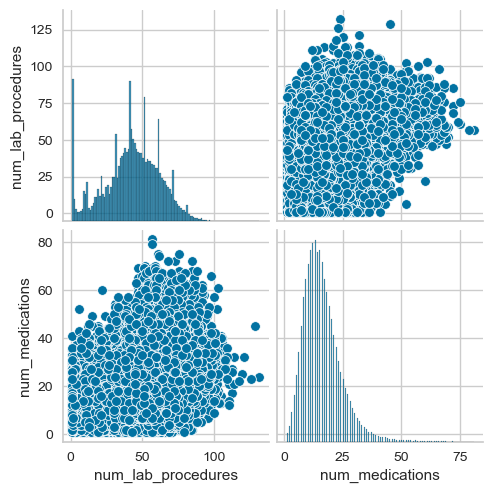

In [144]:
sns.pairplot(continuous_variables)
plt.show()

##### Variables discrètes : num_diagnoses, time_in_hospital et age

In [156]:
discrete_variables_2 = df[['number_diagnoses', 'time_in_hospital', 'age', 'readmitted']]

In [157]:
# Pour rappel de la répartition de la target
df['readmitted'].value_counts()

0    53859
1    46464
Name: readmitted, dtype: int64

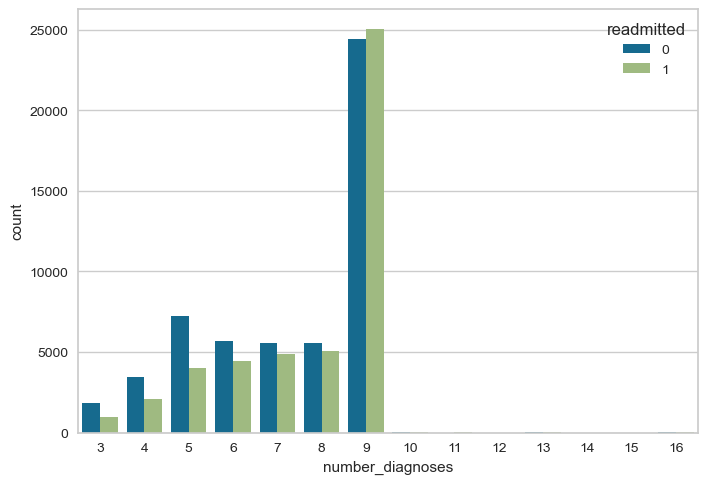

In [158]:
sns.countplot(x='number_diagnoses', hue='readmitted', data = discrete_variables_2)
plt.show()

On compte le nombre d'apparition de diagnostic établi dans le système pour les patients en fonction s'ils ont été réadmis ou non. A noter que notre échantillon 0/1 est respectivement de 53% et 46%. 
Une différence semble se noter à partir de 5 diagnostic déclarés et de surtout à partir de 9. 

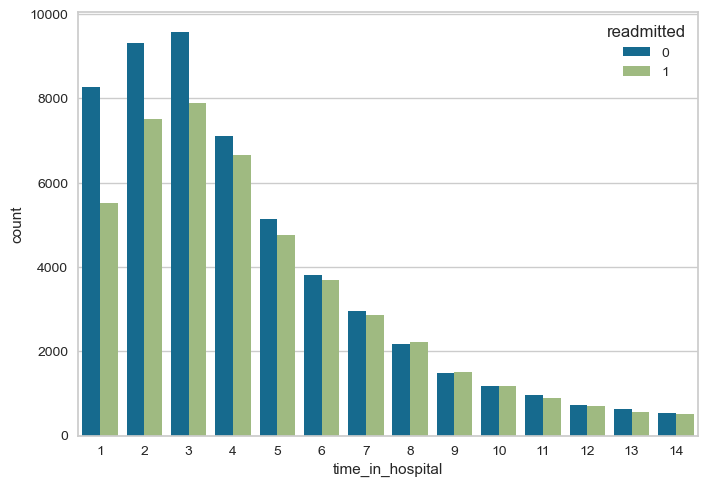

In [159]:
sns.countplot(x='time_in_hospital', hue='readmitted', data = discrete_variables_2)
plt.show()

On observe le nombre d'apparition des patients réadmis ou non en fonction du temps d'hospitalisation. On ne note pas de différence significative, si ce n'est les 3 premiers jours : des temps d'hospitalisation courts semblent être plus propices à une non réadmission. 

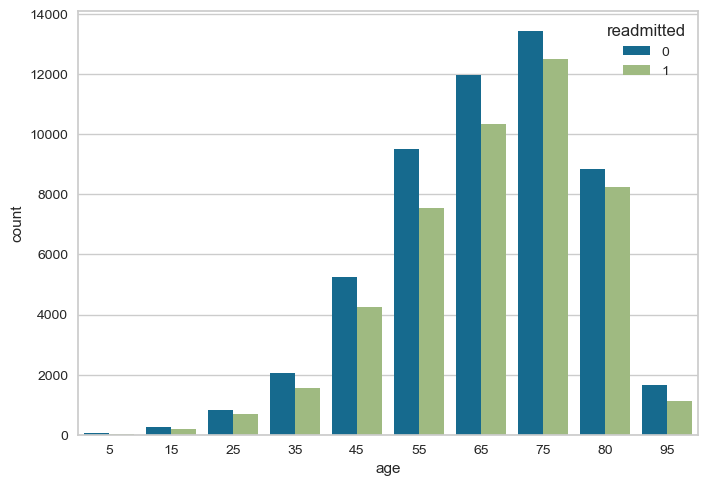

In [160]:
sns.countplot(x='age', hue='readmitted', data = discrete_variables_2)
plt.show()

La variable age ne semble pas discriminante au regard du countplot ci-dessus. Que la patient soit réadmis ou non, la distribution est semblable.

In [164]:
discrete_variables_2.corr()

,number_diagnoses,time_in_hospital,age,readmitted
number_diagnoses,1.000000,0.210214,0.200639,0.107241
time_in_hospital,0.210214,1.000000,0.095755,0.048886
age,0.200639,0.095755,1.000000,0.023373
readmitted,0.107241,0.048886,0.023373,1.000000


##### Variables catégorielles (avec feature engineering)

In [165]:
df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_disposition_transform,admission_source_transform,specialty_transform,payer_code_transform
1,Caucasian,Female,15,1,1,7,3,Inconnu,Inconnu,59,0,18,0,0,0,0,250.01,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,0,Urgences,Inconnu,Inconnu
2,AfricanAmerican,Female,25,1,1,7,2,Inconnu,Inconnu,11,5,13,2,0,1,0,250,0,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,0,Urgences,Inconnu,Inconnu
3,Caucasian,Male,35,1,1,7,2,Inconnu,Inconnu,44,1,16,0,0,0,0,250.43,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,0,Urgences,Inconnu,Inconnu
4,Caucasian,Male,45,1,1,7,1,Inconnu,Inconnu,51,0,8,0,0,0,0,157,1,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,0,Urgences,Inconnu,Inconnu
5,Caucasian,Male,55,2,1,2,3,Inconnu,Inconnu,31,6,16,0,0,0,0,411,1,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,0,Autres,Inconnu,Inconnu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,75,1,3,7,3,MC,Inconnu,51,0,16,0,0,0,1,291,0,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,1,1,Urgences,Inconnu,Medicare
101762,AfricanAmerican,Female,80,1,4,5,5,MC,Inconnu,33,3,18,0,0,1,0,276,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,0,1,Autres,Inconnu,Medicare
101763,Caucasian,Male,75,1,1,7,1,MC,Inconnu,53,0,9,1,0,0,0,590,0,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,0,0,Urgences,Inconnu,Medicare
101764,Caucasian,Female,80,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,0,285,0,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,1,Urgences,Autres,Medicare


In [216]:
categorial_features = df[['discharge_disposition_transform', 'admission_source_transform', 'diag_1', 'diag_3', 'specialty_transform', 'payer_code_transform', 'race', 'gender','change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]

In [181]:
categorial_features

,discharge_disposition_transform,admission_source_transform,diag_1,diag_3,specialty_transform,payer_code_transform,race,gender,change,diabetesMed,max_glu_serum,A1Cresult,metformin,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,readmitted
1,0,Urgences,0,0,Inconnu,Inconnu,Caucasian,Female,Ch,Yes,None,None,No,No,No,No,No,Up,1
2,0,Urgences,0,0,Inconnu,Inconnu,AfricanAmerican,Female,No,Yes,None,None,No,Steady,No,No,No,No,0
3,0,Urgences,0,0,Inconnu,Inconnu,Caucasian,Male,Ch,Yes,None,None,No,No,No,No,No,Up,0
4,0,Urgences,0,1,Inconnu,Inconnu,Caucasian,Male,Ch,Yes,None,None,No,Steady,No,No,No,Steady,0
5,0,Autres,0,1,Inconnu,Inconnu,Caucasian,Male,No,Yes,None,None,No,No,No,No,No,Steady,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,Urgences,1,0,Inconnu,Medicare,AfricanAmerican,Male,Ch,Yes,None,>8,Steady,No,No,No,No,Down,1
101762,1,Autres,0,0,Inconnu,Medicare,AfricanAmerican,Female,No,Yes,None,None,No,No,No,No,No,Steady,0
101763,0,Urgences,0,0,Inconnu,Medicare,Caucasian,Male,Ch,Yes,None,None,Steady,No,No,No,No,Down,0
101764,1,Urgences,0,0,Autres,Medicare,Caucasian,Female,Ch,Yes,None,None,No,Steady,No,Steady,No,Up,0


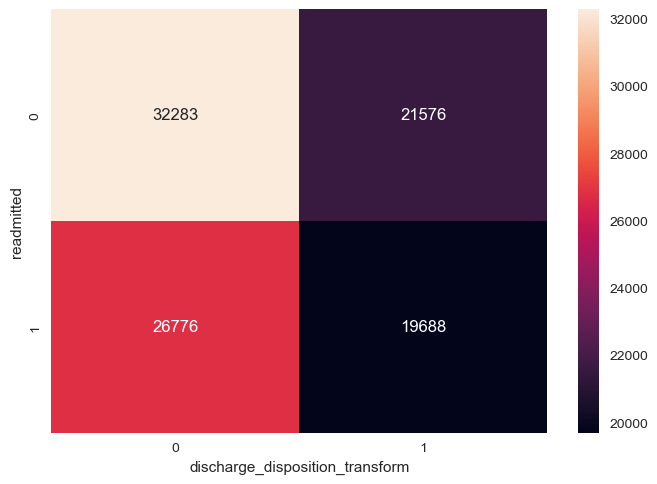

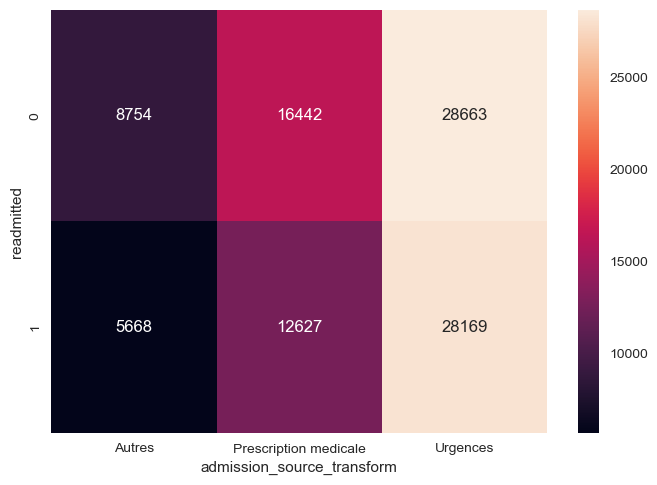

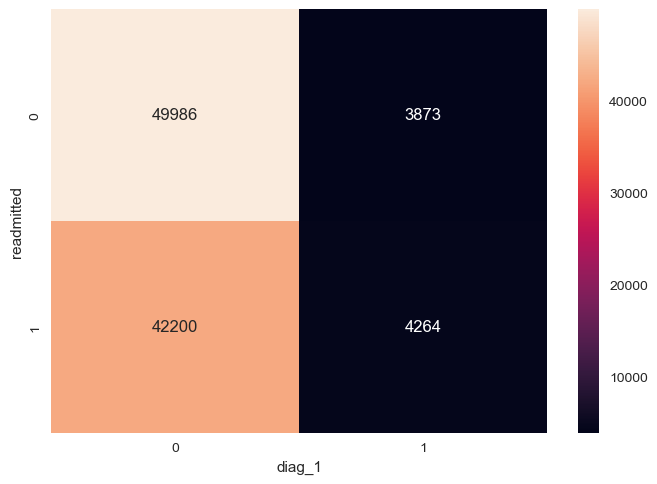

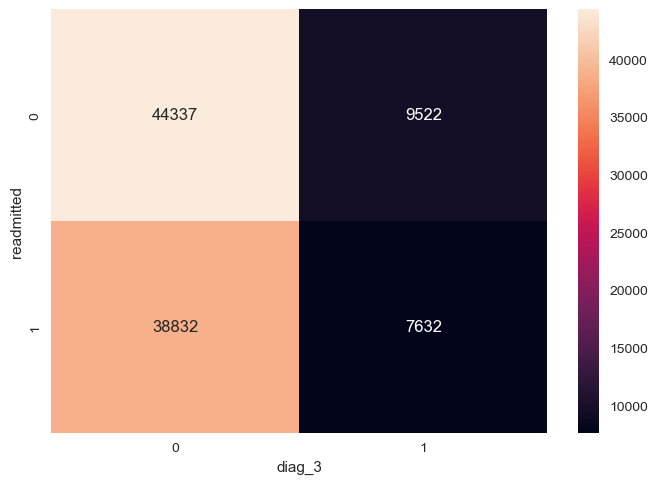

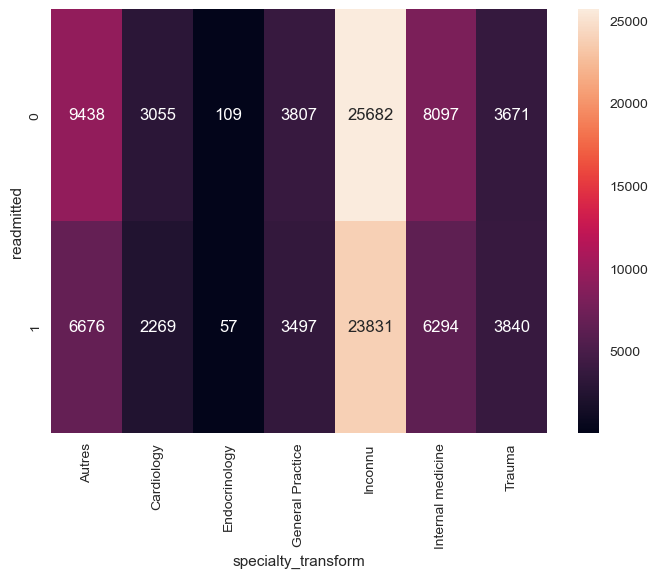

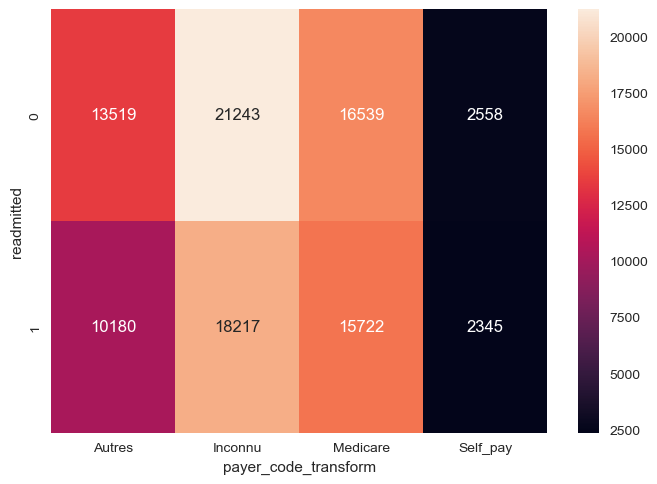

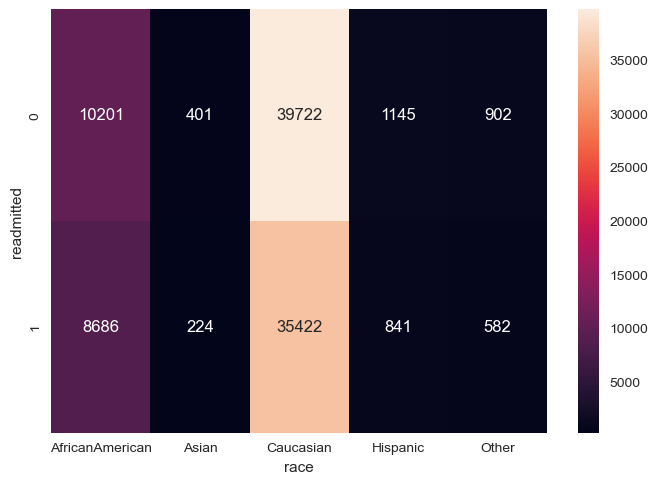

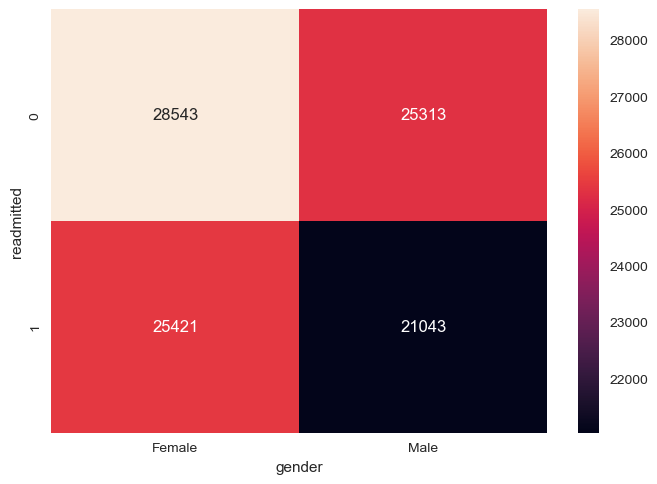

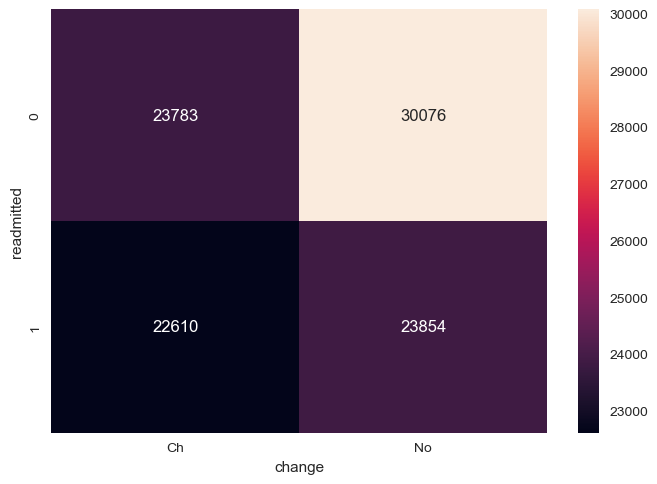

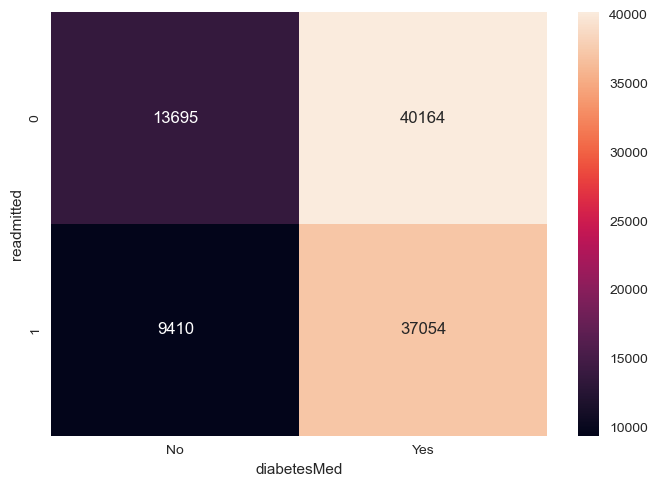

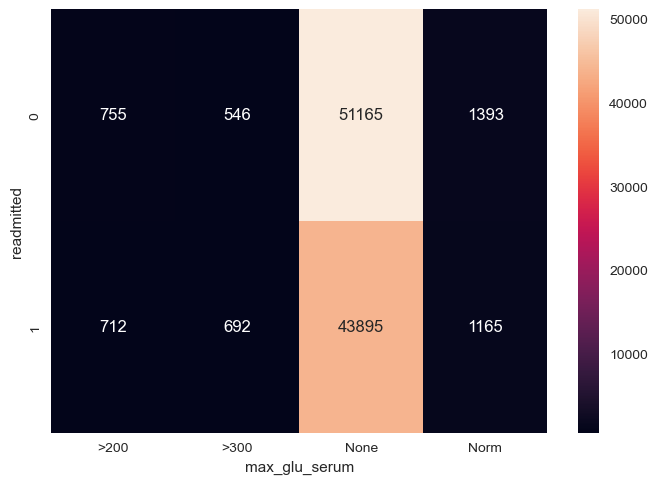

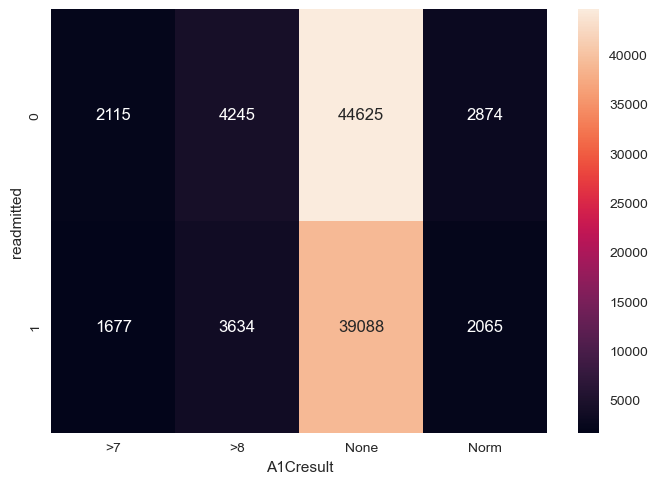

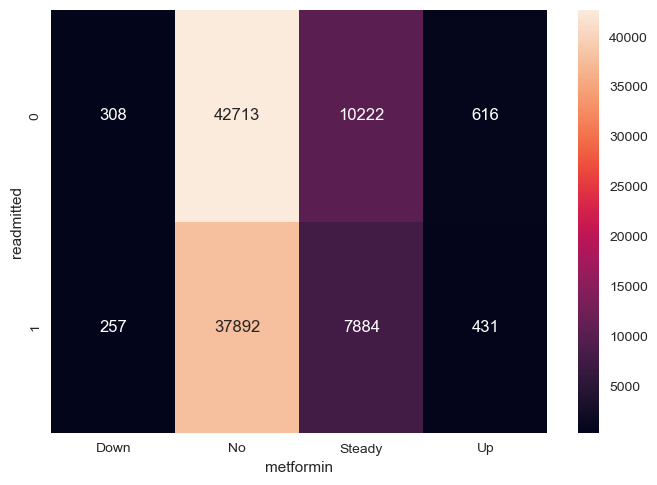

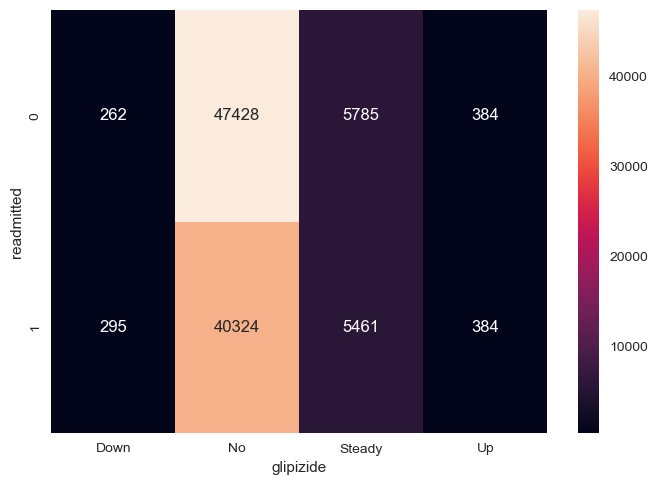

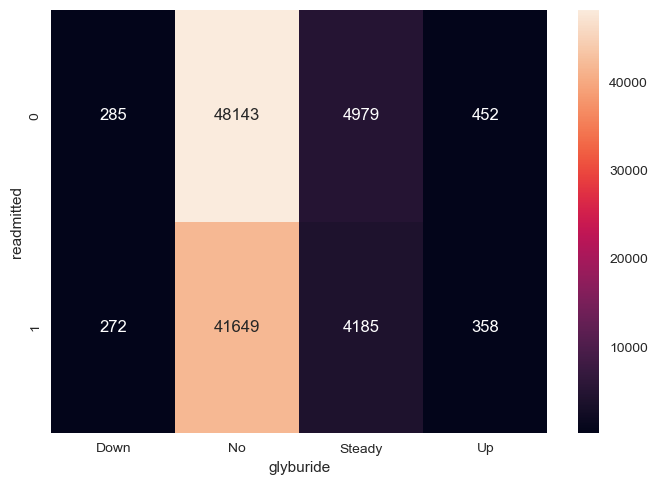

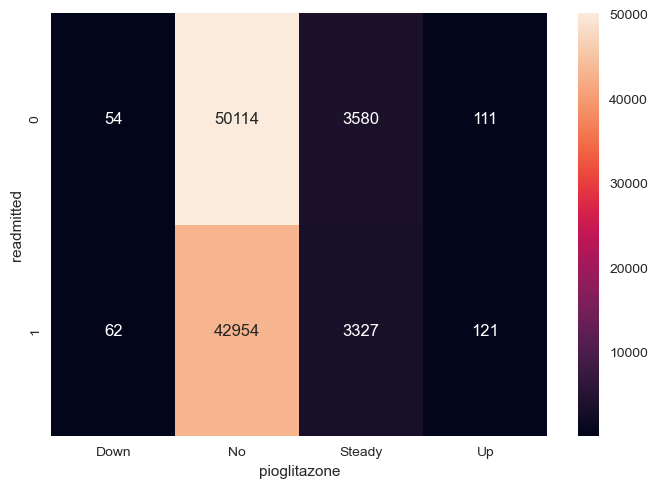

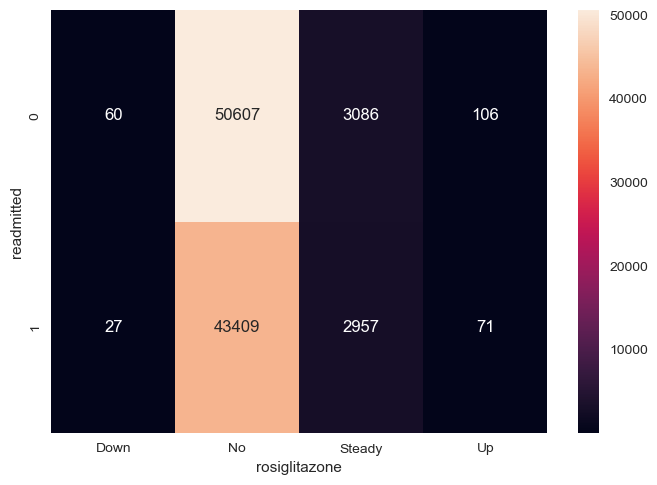

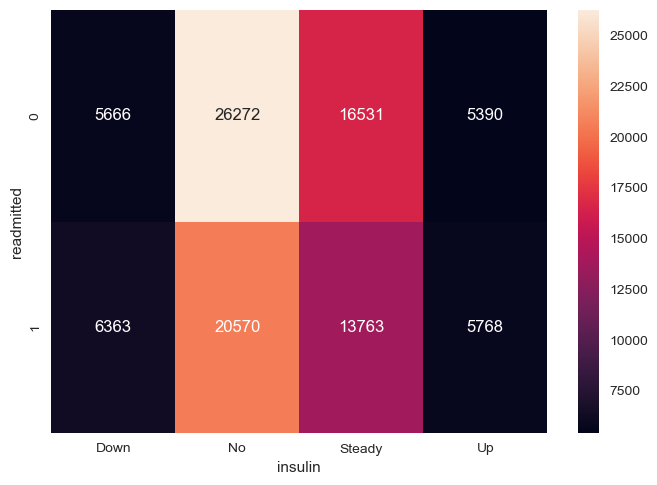

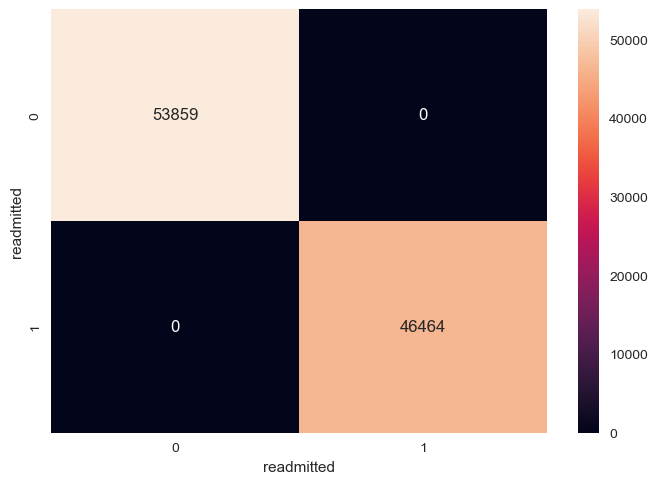

In [183]:
# Crosstab avec la target

for col in categorial_features:
    plt.figure()
    sns.heatmap(pd.crosstab(categorial_features['readmitted'], categorial_features[col]), annot=True, fmt='d')

In [203]:
import researchpy

In [226]:
# Retourne le score de V_cramer

for col in categorial_features:
    crosstab, res = researchpy.crosstab(categorial_features[col],  categorial_features['readmitted'], test='chi-square')
    print(f'{col} -- V de Cramer: {res.iloc[2,1]} / p_value du Chi_2: {res.iloc[1,1]}')

discharge_disposition_transform -- V de Cramer: 0.0234 / p_value du Chi_2: 0.0
admission_source_transform -- V de Cramer: 0.0788 / p_value du Chi_2: 0.0
diag_1 -- V de Cramer: 0.0363 / p_value du Chi_2: 0.0
diag_3 -- V de Cramer: 0.0166 / p_value du Chi_2: 0.0
specialty_transform -- V de Cramer: 0.0611 / p_value du Chi_2: 0.0
payer_code_transform -- V de Cramer: 0.0433 / p_value du Chi_2: 0.0
race -- V de Cramer: 0.0299 / p_value du Chi_2: 0.0
gender -- V de Cramer: 0.0171 / p_value du Chi_2: 0.0
change -- V de Cramer: 0.045 / p_value du Chi_2: 0.0
diabetesMed -- V de Cramer: 0.0613 / p_value du Chi_2: 0.0
max_glu_serum -- V de Cramer: 0.0223 / p_value du Chi_2: 0.0
A1Cresult -- V de Cramer: 0.0227 / p_value du Chi_2: 0.0
metformin -- V de Cramer: 0.0287 / p_value du Chi_2: 0.0
glipizide -- V de Cramer: 0.0203 / p_value du Chi_2: 0.0
glyburide -- V de Cramer: 0.0068 / p_value du Chi_2: 0.2039
pioglitazone -- V de Cramer: 0.0127 / p_value du Chi_2: 0.0011
rosiglitazone -- V de Cramer: 0

D'après les résultats, aucune des variables n'a de relation forte avec la target car tous les résultats sont inférieure à 0.10
Noius décidons de toutes les garder tout de même pour entrainer notre modèle (après avoir procédé au pre-processing). 

#### Relation des variables entre elles

A faire : 

- Regarder si la relation entrela probabilité de réadmission et le fait d'avoir mesurer la glycémie glyquée dépend du diagnotic - payer_code et temps d'hospitalisation
- antidiabétiques oraux et résultats de la glycémie

<Figure size 800x550 with 0 Axes>

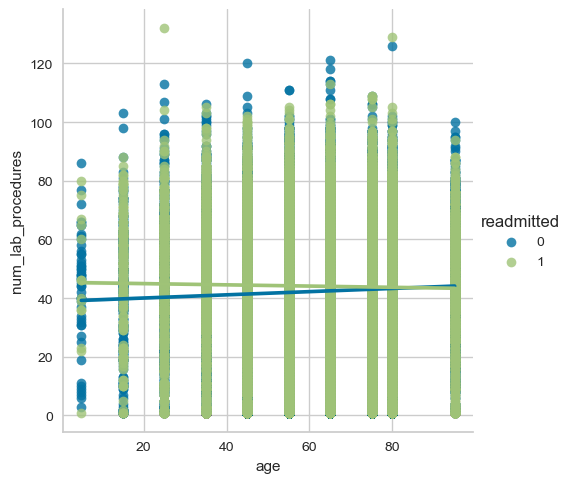

<Figure size 800x550 with 0 Axes>

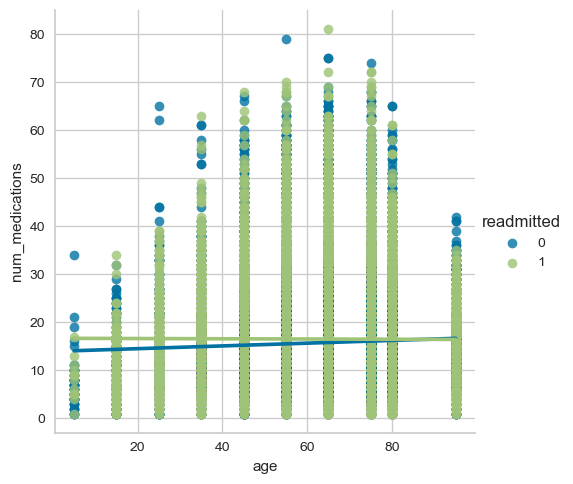

In [229]:
# test

for col in continuous_variables:
    plt.figure()
    sns.lmplot(x='age', y=col, hue='readmitted', data=df)

In [230]:
# test

df.corr()['readmitted']

age                                0.023373
admission_type_id                 -0.004944
discharge_disposition_id          -0.016062
admission_source_id                0.039683
time_in_hospital                   0.048886
num_lab_procedures                 0.037849
num_procedures                    -0.046857
num_medications                    0.043164
number_outpatient                  0.081323
number_emergency                   0.102143
number_inpatient                   0.215666
number_diagnoses                   0.107241
readmitted                         1.000000
discharge_disposition_transform    0.023433
Name: readmitted, dtype: float64

### Data cleaning 

Etapes : 
- copie du dataset
- suppression des nulles
- sélection des variables à garder (suite à l'EDA)

#### Sélection des variables

On sélectionne les colonnes que nous avons identifiées comme utiles lors de l'EDA : nous avons 101766 exemples et 22 variables. 

In [341]:
df_2 = base_clean_dataset()

In [249]:
df_2.head(2)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,5,NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,15,NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1


In [342]:
# Sélection des variables

df_2 = df_2[['num_lab_procedures','num_medications', 'number_diagnoses', 'time_in_hospital', 'age', 'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty', 'payer_code', 'race', 'gender', 'change', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride', 'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted']]

In [251]:
df_2.head(2)

,num_lab_procedures,num_medications,number_diagnoses,time_in_hospital,age,discharge_disposition_id,admission_source_id,diag_1,diag_3,medical_specialty,payer_code,race,gender,change,diabetesMed,max_glu_serum,A1Cresult,metformin,glimepiride,pioglitazone,rosiglitazone,insulin,readmitted
0,41,1,1,1,5,25,1,250.83,NaN,Pediatrics-Endocrinology,NaN,Caucasian,Female,No,No,None,None,No,No,No,No,No,0
1,59,18,9,3,15,1,7,276,255,NaN,NaN,Caucasian,Female,Ch,Yes,None,None,No,No,No,No,Up,1


In [321]:
df_2.shape

(101766, 23)

#### Gestion des valeurs manquantes

Comme vu lors de l'EDA : 
- exclusion de la variable "weight" qui possédait trop de valeurs nulles
- suppression des 3 colonnes pour lesquelles nous avons quelques lignes nulles
- Remplacement des valeurs nulles dans medical_speciality et payer_code par 'Inconnu'

Nous avons désormais 98125 exemples et 22 colonnes.

In [252]:
check_null_values(df_2)

,nombre_null,%_null
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_1,21,0.0
gender,3,0.0
diabetesMed,0,0.0
insulin,0,0.0
rosiglitazone,0,0.0
pioglitazone,0,0.0


In [343]:
def null_cleaning(df):
    df = df.replace({'medical_specialty' : {np.nan : 'Inconnu'}}).replace({'payer_code' : {np.nan : 'Inconnu'}})
    df = df.dropna()
    return df

In [344]:
df_2 = null_cleaning(df_2)

In [325]:
df_2.shape

(98125, 23)

### Preprocessing

In [262]:
df_2.columns

Index(['num_lab_procedures', 'num_medications', 'number_diagnoses',
       'time_in_hospital', 'age', 'discharge_disposition_id',
       'admission_source_id', 'diag_1', 'diag_3', 'medical_specialty',
       'payer_code', 'race', 'gender', 'change', 'diabetesMed',
       'max_glu_serum', 'A1Cresult', 'metformin', 'glimepiride',
       'pioglitazone', 'rosiglitazone', 'insulin', 'readmitted'],
      dtype='object')

Récapitulatif des transformations à apporter en termes de preprocessing suite à l'EDA : 

- suppression des outliers :
    - num_lab_procedures
    - num_medications
    - number_diagnoses
    - age  
    

- passer en logarithme : 
    - time_in_hospital

- encodage ordinal : 
    - change
    - diabetesMed
    - max_glu_serum
    - A1Cresult
    - metformin
    - glimepiride
    - pioglitazone
    - rosiglitazone
    - insulin

- feature engineering:
    - discharge_disposition_id (0/1)
    - admission_source_id (Urgences/Prescription medicale/Autres) => puis à OneHotEncoder
    - diag_1 / diag_3 (0/1)
    - medical_specialty => puis à OneHotEncoder
    - payer_code => puis à OneHotEncoder


- encodage OneHot : 
    - admission_source_transform
    - medical_specialty_transform
    - payer_code_transform
    - race
    - gender
    

#### Train Test Split

L'objectif est de découper le jeu d'entrainement en un train (sur lequel notre modèle va apprendre) et le test (qui doit être mis de côté sans jamais y toucher => éviter à tout prix le data leakage.

In [346]:
# Split des variables et la target

X = df_2.drop(columns=['readmitted'], axis=1)
y = df_2[['readmitted']]

In [347]:
# Split du dataset entre un jeu de données de train et de test

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=5, stratify=y)

print('Train set :', X_train.shape)
print('Test set :', X_test.shape)

Train set : (78500, 22)
Test set : (19625, 22)


In [260]:
# Répartition de la target sur le y_train

analyse_target(y_train)

,number,%
0,41896,53.4
1,36604,46.6


In [261]:
# Répartition de la target sur le y_train

analyse_target(y_test)

,number,%
0,10474,53.4
1,9151,46.6


La target constitue des classes bien équilibrées (pour le train et le test).

#### Suppression des outliers

In [265]:
def remove_outliers(df, col_name):

    # Définit les percentiles 25% et 75% et calcule le IQR
    Q1 = np.percentile(df[col_name], 25)
    Q3 = np.percentile(df[col_name], 75)
    IQR = Q3 - Q1
    print("Old Shape: ", df.shape)

    # Détection des outliers (fourchette haute et basse)
    upper = np.where(df[col_name] > (Q3+1.5*IQR))
    lower = np.where(df[col_name] < (Q1-1.5*IQR))
    
    # Suppression des outliers
    df = df.reset_index(drop=True)  
    df = df.drop(upper[0], axis=0) 
    df = df.drop(lower[0],axis=0)
    print("New Shape: ", df.shape)
    
    return df

In [338]:
def remove_outliers_dataset(df):
    '''Retire les outliers des colonnes spécifiées
       A factoriser
    '''
    df = remove_outliers(df, 'num_lab_procedures')
    df = remove_outliers(df, 'num_medications')
    df = remove_outliers(df, 'number_diagnoses')
    df = remove_outliers(df, 'age')
    
    return df

In [349]:
df_2.shape

(98125, 23)

In [350]:
df_2 = remove_outliers_dataset(df_2)

Old Shape:  (98125, 23)
New Shape:  (97983, 23)
Old Shape:  (97983, 23)
New Shape:  (94713, 23)
Old Shape:  (94713, 23)
New Shape:  (94662, 23)
Old Shape:  (94662, 23)
New Shape:  (94134, 23)


In [352]:
df_2.shape

(94134, 23)

#### Appliquer le logarithme

In [292]:
def logarithme(df):
    df['time_in_hospital'] = np.log(df[['time_in_hospital']])
    return df

In [353]:
df_2 = logarithme(df_2)

In [ ]:
def preprocessing(df):
    df = remove_outliers_dataset(df)
    df = logarithme(df)
    
    

#### Encodage

Nous allons procéder à des transformations manuelles sans utiliser le module OrdinalEncoder de Sklearn par exemple car nous avons besoin de personnaliser l'encodage selon le type de variable. L'industrialisation à l'aide des imputer de sklearn semble limitée. 

In [ ]:
df_2.head()

In [ ]:
df_2['payer_code'].nunique()

In [ ]:
df_2['discharge_disposition_id'].value_counts()

In [ ]:
# test si on peut dans une fonction faire du OneHotEncodeer
def enco(df):
    X = [['race']]
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(X)
    return df

In [ ]:
X_train.head(2)

In [ ]:
encoder = OneHotEncoder()
encoder.fit_transform(X_train[['race']])

In [ ]:
#######
# utiliser le make_column_transformer ? https://datagy.io/sklearn-one-hot-encode/

encoder = OrdinalEncoder()
X_train = encoder.fit_transform(X_train[['gender']])

In [ ]:
X_train

In [ ]:
def encodage(df):
    

#### Feature engineering

#### Normalisation

#### Gestion des outliers

#### Normalisation

#### Transformation

In [ ]:
def transformation_post_eda(df):
    
    # age
    df = age_transform_to_numeric(df)
    
    # diag_1 - voir si possible de faire l'encodage dans le OrdinalEncoder directement via le pipeline
    df.dropna(subset='diag_1', inplace=True)
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == True] = 1
    df['diag_1'].loc[df['diag_1'].str.startswith('250') == False] = 0
    
    # medical_specialty
#     df = df.replace({'medical_specialty' : {np.nan : 'Inconnu'}})
    df['specialty_transform'] = df.apply(medical_transform, axis=1)
    
    return df

In [ ]:
df_2 = transformation_post_eda(df_2)

In [ ]:
df_2.head()

In [ ]:
df_2.shape

### preprocessing

In [ ]:
df_2.head()

In [ ]:
# pipeline encodage 

numerical_features = X.select_dtypes(include=['float', 'integer']).columns.values
categorical_features = X.select_dtypes(include=['object']).columns.values

In [ ]:
numerical_features

In [ ]:
categorical_features

In [ ]:
numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OrdinalEncoder())

In [ ]:
preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                   (categorical_pipeline, categorical_features))

### Evaluation du modèle

In [ ]:
model_2 = make_pipeline(preprocessor, LogisticRegression(random_state = 5, solver='sag'))

In [ ]:
evaluation_cv(model_2, X_train, y_train.values.ravel())

In [ ]:
y_pred_cv_2 = cross_val_predict(model_2, X_train, y_train.values.ravel(), cv=5)
y_pred_cv_2

In [ ]:
conf_cv = pd.DataFrame(confusion_matrix(y_train, y_pred_cv_2))
conf_cv = conf_cv.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
conf_cv= conf_cv.rename(index={0: 'Actual 0',1:"Actual 1"})
conf_cv 

In [ ]:
print(classification_report(y_train, y_pred_cv_2))

Le fait d'avoir supprimé les outliers a permis d'augmenter un tout petit peu le score (comparativement avec les résultats affichés dans le rapport). Maintenant, il faut tester l'encodage correct.

#### _coef

In [ ]:
model_2.fit(X_train, y_train.values.ravel())
model_2._coef

# Itération 3 : analyse des résidus et Decision Tree

## Decison Tree classifier

In [ ]:
On veut utiliser ce modèle car il est très simple à interpréter et permet de voir assez rapidement 

# Idées en vrac

- Pour le nettoyage des données : 
    - Voir comment gérer la colonne 'race' : pour le même id = pas la même race attribuée
- Feature engineering 
    - nb d'admissions par patient mais sera sûrement biaisé car fortement corrélé à la target : si le patient présente plusieurs lignes dans le dataset, c'est forcément qu'il a été réadmis. Il serait peut-être plus intéressant de noter la différence de traitement entre les différentes admissions (augmentation de la glycémie à jeun/glyquée, différence de traitement)
    - Gestion des 3 variables id encodées en ordinal mais qui sont en réalité des catégorielles. Les passer en string puis les encoder en OneHot. Ex : baseline['admission_type_id'].map(lambda x: str(x))
- Gestion des variables qualitatives 
    - cross_tab Khi 2
- precision-recall curve : Après avoir trouvé le bon modèle et régler les hyperparamètres, gérer le bon threshold entre la precision et le recall grace au  : https://www.scikit-yb.org/en/latest/api/classifier/prcurve.html